In [1]:
import pandas as pd
from utils import *
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pytrends.request import TrendReq
import requests
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import bootstrap
import statsmodels.api as sm
from sklearn.metrics import r2_score
from scipy.stats import bootstrap

C:\Users\zmugm1\AppData\Local\Temp\ipykernel_12412\1345650799.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#! pip install wbgapi
#! pip install pandas
#! pip install matplotlib
#! pip install scipy
#! pip install -U notebook-as-pdf
#! pip install numpy
#! pip install scikit-learn
#! pip install vaderSentiment
#! pip install transformers sentencepiece
#! pip install torch torchvision torchaudio
#! pip install networkx
#! pip install seaborn
#! pip install -U pytrends
#! pip install requests
#! pip install statsmodels

#! pip install rpy2
#! pip install pymer4

In [ ]:
@everyone die Tabelle data/new.csv enthält die Daten bisher (ich muss noch die neuen Faktoren hinzufügen, aber ein paar sind schon drin). 
Könntet ihr ein paar Plots zur Verteilung der Daten machen?
Die Spalten GINI_HND,I_IUSNET,F10_RT sind die Faktoren. Alle anderen Spalten sind die verschiedenen Verbrechen, jeweils in absolut und normiert. Ich würde die normierten nehemen, die Spalten haben jeweils die Endung _P_HTHAB, also z.B. ICCS05021_P_HTHAB.
Intentional homicide könnte interessant sein, das wäre crime code ICCS0101

ICCS0101    Mord 
ICCS0102:   versuchter Mord

ICCS020111: Schwere Körperverletzung 

ICCS020221: Entführung

ICCS0301:   Sexuelle Gewalt 
ICCS03011:  Vergewaltigung 
ICCS03012:  Sexuelle Übergriffe
ICCS0302:   Sexuelle Ausbeutung 

ICCS0401:   Raub 

ICCS0501:   Einbruch
ICCS05012:  Einbruch in private Wohnräume 

ICCS0502:   Diebstahl
ICCS05021:  Diebstahl eines motorisierten Fahrzeugs oder Teilen davon

ICCS0601:   Rechtswidrige Handlungen im Zusammenhang mit kontrollierten Drogen oder Vorläuferstoffen

ICCS0701:   Betrug 
ICCS0703:   Korruption 
ICCS07031:  Bestechung

ICCS07041:  Geldwäsche 
ICCS09051:  Beteiligung an einer organisierten kriminellen Vereinigung

ICCS0903:   Handlungen gegen Computersysteme



In [3]:

def normalize(df, column_name='metroreg'):
    delimiter = ":"
    new_column_names = [column_name, column_name + '_d']
    #print(new_column_names,'//',delimiter,'//',column_name)
    df[new_column_names] = df[column_name].str.split(delimiter, expand=True)
    
    #df.dropna(subset=['OBS_VALUE'], inplace=True)
    return df

def grouping(df, rename='value', agg='mean', cols_to_groupby=['metroreg', 'TIME_PERIOD']):
    #print(df, rename, agg, cols_to_groupby)
    #df.dropna(subset=['OBS_VALUE'], inplace=True)
    #exec(f"df = df.groupby(['metroreg', {add}]).agg({{'OBS_VALUE': {agg}}})")

    df = df.groupby(cols_to_groupby).agg({'OBS_VALUE': agg}) ##, 'geo_d': 'max'})
    df.rename(columns={'TIME_PERIOD': 'year'}, inplace=True)
    df.rename(columns={'OBS_VALUE': rename}, inplace=True)
    df = df.reset_index()
    return df

def label_metroreg(row):
    if len(row['metroreg']) == 2:
        return 'R'
    elif 'N' in row['metroreg']:
        return 'N'
    else:
        return 'M'

In [4]:
tablelist = [\
             ('dfgdp','gdp',"../raw_data/GDP_metro_10r_3gdp_linear.csv",'mean',["metroreg", "TIME_PERIOD", "unit"]), \
             ('dfarea','area',"../raw_data/Area_estat_met_d3area_en.csv",'mean',["metroreg", "TIME_PERIOD"]), \
             #('dfhtec','htec',"../raw_data/HighTec_patents_met_pat_eptec_linear.csv",'mean'), \
             ('dfpop','population',"../raw_data/Population_met_pjangrp3_linear.csv",'mean',["metroreg", "TIME_PERIOD"\
                                                                                           # , "dfpop_sex", "dfpop_age"
                                                                                           ]), \
             ('dfunemp','unemp per Tsd.',"../raw_data/Unemployment_met_lfu3pers_linear.csv",'mean',["metroreg", "TIME_PERIOD", "dfunemp_sex", "dfunemp_age"]),\
             ('dfcrime','Nr_Crimes',"../raw_data/Crime_in_Metropoles_estat_met_crim_gen_en.csv",'sum',["metroreg", "TIME_PERIOD", "iccs"])]

#Nachschauen worauf sich d_alc der Wert bezieht!!!!
## Wie wird poverty das gemessen?????
for dataframe, name, value, agg, add in tablelist:
    exec(f"{dataframe} = pd.read_csv('{value}')")
    #exec(f"print('{dataframe}', len({dataframe}) )")   
    #exec(f"print({dataframe})")

dfarea  = dfarea.loc[dfarea ['landuse'] == 'TOTAL:Total area']
dfcrime = dfcrime[dfcrime['unit'].str.startswith('NR:Number')]

dfpop = dfpop.loc[dfpop ['sex'] == 'T:Total']
dfpop   = dfpop[dfpop['age'].str.startswith('TOTAL:Total')]
#dfpop.rename(columns={'sex': 'dfpop_sex'}, inplace=True)
#dfpop.rename(columns={'age': 'dfpop_age'}, inplace=True)

#dfgdp = dfgdp[dfgdp['unit'].str.startswith('PPS_HAB_EU27_2020')]
#['Y15-24:From 15 to 24 years' 'Y15-29:From 15 to 29 years' 'Y15-74:From 15 to 74 years' 'Y20-64:From 20 to 64 years' 'Y_GE15:15 years or over' 'Y_GE25:25 years or over']

#dfunemp = dfunemp.loc[dfunemp['sex'].isin(['M:Males', 'T:Total'])]
#dfunemp = dfunemp[dfunemp['age'].str.startswith('Y15-74' or 'Y15-29')]
#print(dfunemp['age'].unique())
prefixes = ['Y15-74']#', 'Y15-24']
dfunemp = dfunemp[dfunemp['age'].str.startswith(tuple(prefixes))]

dfunemp.rename(columns={'sex': 'dfunemp_sex'}, inplace=True)
dfunemp.rename(columns={'age': 'dfunemp_age'}, inplace=True)
dfunemp.rename(columns={'unit': 'dfunemp_unit'}, inplace=True)

dfall = dfarea
dfall = dfall.reset_index()
dfall.drop(columns=dfall.columns.difference(['metroreg', 'TIME_PERIOD']), axis=1, inplace=True)


for dataframe, name, value, agg, add in tablelist:
    exec(f"{dataframe} = grouping({dataframe}, '{name}', '{agg}', {add})")
    #exec(f"print(dfall.dtypes)")
    #exec(f"print({dataframe}.dtypes)")
    exec(f"dfall = pd.merge(dfall, {dataframe}, on=['metroreg', 'TIME_PERIOD'], how='inner')")

dfall = normalize(dfall)
dfall['metroreg_type'] = dfall.apply(label_metroreg, axis=1)
dfall = normalize(dfall,'iccs')


dfall['unemp_rate']  = dfall['unemp per Tsd.'] * 1000 * 100 / dfall['population']
dfall['crimes_rate'] = dfall['Nr_Crimes'] * 1000 * 100 / dfall['population']
dfall['density']       = dfall['population'] / dfall['area']
dfall['unemp_area']  = dfall['unemp per Tsd.'] * 1000 * 100 / dfall['area']

#print(dfall)

dfall.to_csv('../data/df_allmetro_all.csv', index=False)
print(dfall["unit"].unique())
print(dfall["iccs"].unique())

['EUR_HAB:Euro per inhabitant'
 'EUR_HAB_EU27_2020:Euro per inhabitant in percentage of the EU27 (from 2020) average'
 'MIO_EUR:Million euro' 'MIO_NAC:Million units of national currency'
 'MIO_PPS_EU27_2020:Million purchasing power standards (PPS, EU27 from 2020)'
 'PPS_EU27_2020_HAB:Purchasing power standard (PPS, EU27 from 2020), per inhabitant'
 'PPS_HAB_EU27_2020:Purchasing power standard (PPS, EU27 from 2020), per inhabitant in percentage of the EU27 (from 2020) average']
['ICCS0101' 'ICCS0401' 'ICCS05012' 'ICCS050211']


In [5]:
dfout = dfall
#dfout = dfout.loc[dfout['metroreg_type'].isin(['M', 'N'])]
dfout.dropna(subset=['unemp per Tsd.'], inplace=True)
dfout.dropna(subset=['Nr_Crimes'], inplace=True)
dfout.dropna(subset=['gdp'], inplace=True)
dfout.dropna(subset=['area'], inplace=True)
dfout.dropna(subset=['population'], inplace=True)
#dfout = dfout.loc[dfout['TIME_PERIOD'] < 2020]
#dfout = dfout.loc[dfout['dfunemp_sex'] == 'M:Males']

#print(dfout['dfunemp_sex'].unique())
#dfout   = dfout[dfout['dfunemp_sex'].str.startswith('T:Total')]
dfout



metroreg  TIME_PERIOD  \
0           AT         2014   
1           AT         2014   
2           AT         2014   
3           AT         2014   
4           AT         2014   
...        ...          ...   
89112       TR         2020   
89113       TR         2020   
89114       TR         2020   
89115       TR         2020   
89116       TR         2020   

                                                    unit      gdp      area  \
0                            EUR_HAB:Euro per inhabitant  39000.0   83882.0   
1                            EUR_HAB:Euro per inhabitant  39000.0   83882.0   
2                            EUR_HAB:Euro per inhabitant  39000.0   83882.0   
3                            EUR_HAB:Euro per inhabitant  39000.0   83882.0   
4                            EUR_HAB:Euro per inhabitant  39000.0   83882.0   
...                                                  ...      ...       ...   
89112  PPS_HAB_EU27_2020:Purchasing power standard (P...     61.0  780270.0   
89113  PPS_HAB_EU27_2020:Purchasing power standard (P...     61.0  780270.0   
89114  PPS_HAB_EU27_2020:Purchasing power standard (P...     61.0  780270.0   
89115  PPS_HAB_EU27_2020:Purchasing power standard (P...     61.0  780270.0   
89116  PPS_HAB_EU27_2020:Purchasing power standard (P...     61.0  780270.0   

       population dfunemp_sex                 dfunemp_age  unemp per Tsd.  \
0       8507786.0   F:Females  Y15-74:From 15 to 74 years           110.2   
1       8507786.0   F:Females  Y15-74:From 15 to 74 years           110.2   
2       8507786.0   F:Females  Y15-74:From 15 to 74 years           110.2   
3       8507786.0   F:Females  Y15-74:From 15 to 74 years           110.2   
4       8507786.0     M:Males  Y15-74:From 15 to 74 years           134.7   
...           ...         ...                         ...             ...   
89112  83154997.0     M:Males  Y15-74:From 15 to 74 years          2596.9   
89113  83154997.0     T:Total  Y15-74:From 15 to 74 years          4044.9   
89114  83154997.0     T:Total  Y15-74:From 15 to 74 years          4044.9   
89115  83154997.0     T:Total  Y15-74:From 15 to 74 years          4044.9   
89116  83154997.0     T:Total  Y15-74:From 15 to 74 years          4044.9   

             iccs  Nr_Crimes metroreg_d metroreg_type  \
0        ICCS0101         40    Austria             R   
1        ICCS0401       3481    Austria             R   
2       ICCS05012      16947    Austria             R   
3      ICCS050211       1062    Austria             R   
4        ICCS0101         40    Austria             R   
...           ...        ...        ...           ...   
89112  ICCS050211      32509    Türkiye             R   
89113    ICCS0101       1958    Türkiye             R   
89114    ICCS0401      11267    Türkiye             R   
89115   ICCS05012      58400    Türkiye             R   
89116  ICCS050211      32509    Türkiye             R   

                                         iccs_d  unemp_rate  crimes_rate  \
0                          Intentional homicide    1.295284     0.470158   
1                                       Robbery    1.295284    40.915463   
2      Burglary of private residential premises    1.295284   199.194009   
3             Theft of a motorized land vehicle    1.295284    12.482684   
4                          Intentional homicide    1.583256     0.470158   
...                                         ...         ...          ...   
89112         Theft of a motorized land vehicle    3.122963    39.094464   
89113                      Intentional homicide    4.864290     2.354639   
89114                                   Robbery    4.864290    13.549396   
89115  Burglary of private residential premises    4.864290    70.230295   
89116         Theft of a motorized land vehicle    4.864290    39.094464   

          density  unemp_area  
0      101.425646  131.375027  
1      101.425646  131.375027  
2      101.425646  131.375027  
3      101.425646  131.375027  
4

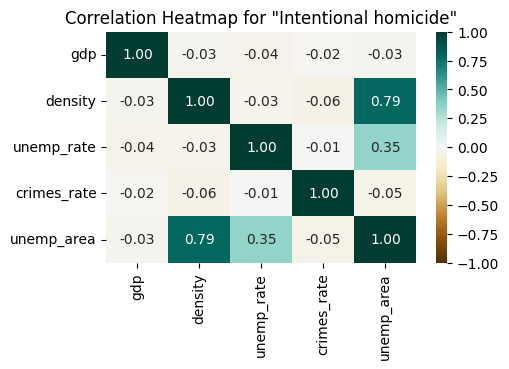

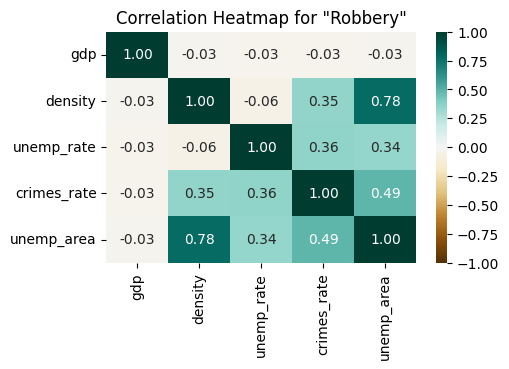

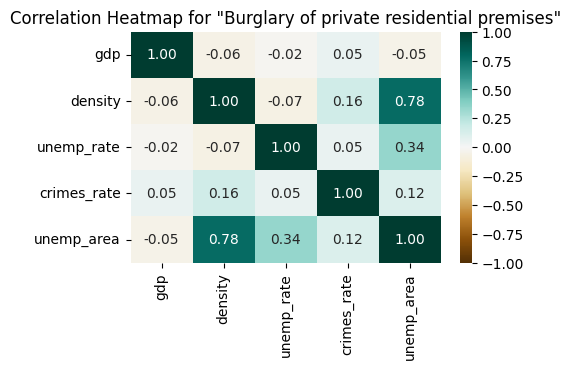

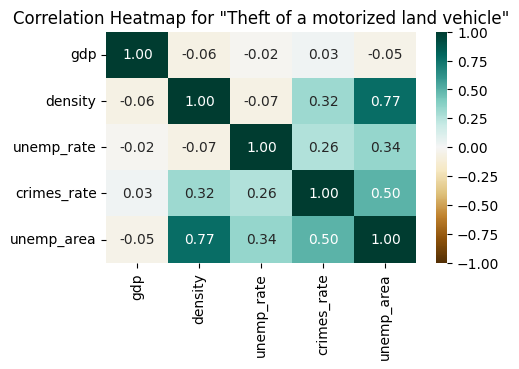

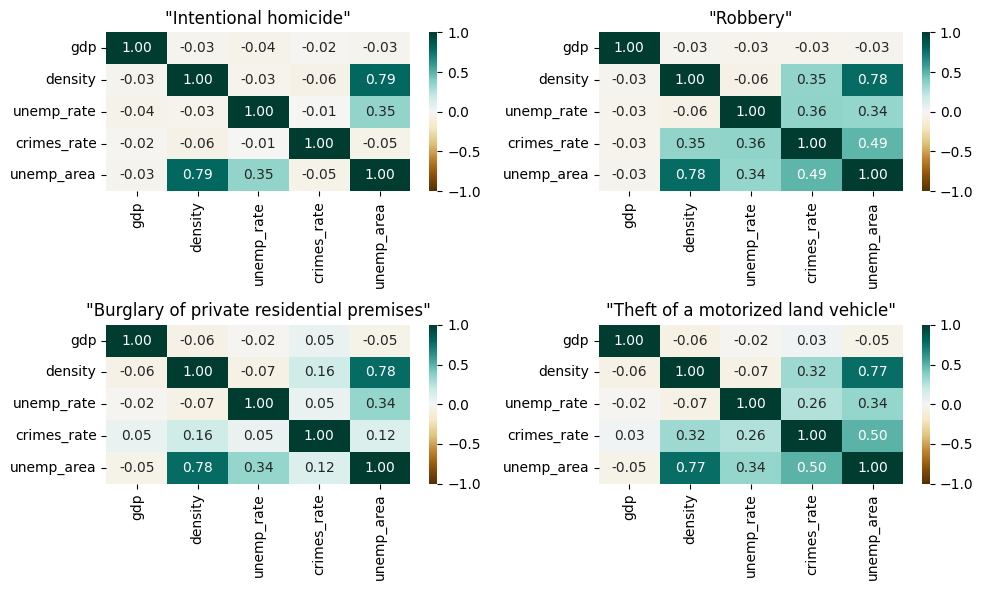

In [6]:
subset = dfout[dfout['dfunemp_sex'] == 'T:Total'] 


for iccs in subset['dfunemp_sex'].unique():
    subset = dfout[dfout['dfunemp_sex'] == iccs]
    for usex in dfout['iccs_d'].unique():
        uset = subset[subset['iccs_d'] == usex]

        corr = uset[[\
            #'Nr_Crimes', 'unemp per Tsd.', 'population',  'area', 
            'gdp', 'density', 'unemp_rate', 'crimes_rate', 'unemp_area']].corr()
    
    # Plot the heatmap
        plt.figure(figsize=(5, 3))
        sns.heatmap(corr, vmin='-1', vmax='1', annot=True, fmt=".2f", cmap='BrBG')
        plt.title(f'Correlation Heatmap for "{usex}"')
        plt.savefig(f"../plots/{usex}_heatmap.png")
        plt.show()
        

fig, axs = plt.subplots(2, 2, figsize=(10, 6))

uset1 = subset[subset['iccs'] == 'ICCS0101']
uset2 = subset[subset['iccs'] == 'ICCS0401']
uset3 = subset[subset['iccs'] == 'ICCS05012']
uset4 = subset[subset['iccs'] == 'ICCS050211']

corr = uset1[['gdp', 'density', 'unemp_rate', 'crimes_rate', 'unemp_area']].corr()
sns.heatmap(corr, vmin='-1', vmax='1', annot=True, fmt=".2f", cmap='BrBG', ax=axs[0, 0])
axs[0, 0].set_title(f'"{uset1["iccs_d"].unique()[0]}"')

corr = uset2[['gdp', 'density', 'unemp_rate', 'crimes_rate', 'unemp_area']].corr()
sns.heatmap(corr, vmin='-1', vmax='1', annot=True, fmt=".2f", cmap='BrBG', ax=axs[0, 1])
axs[0, 1].set_title(f'"{uset2["iccs_d"].unique()[0]}"')

corr = uset3[['gdp', 'density', 'unemp_rate', 'crimes_rate', 'unemp_area']].corr()
sns.heatmap(corr, vmin='-1', vmax='1', annot=True, fmt=".2f", cmap='BrBG', ax=axs[1, 0])
axs[1, 0].set_title(f'"{uset3["iccs_d"].unique()[0]}"')

corr = uset4[['gdp', 'density', 'unemp_rate', 'crimes_rate', 'unemp_area']].corr()
sns.heatmap(corr, vmin='-1', vmax='1', annot=True, fmt=".2f", cmap='BrBG', ax=axs[1, 1])
axs[1, 1].set_title(f'"{uset4["iccs_d"].unique()[0]}"')

plt.tight_layout()
#plt.savefig(f"../plots/heatmap_all.png")
plt.show()

(0.0, 1.0)


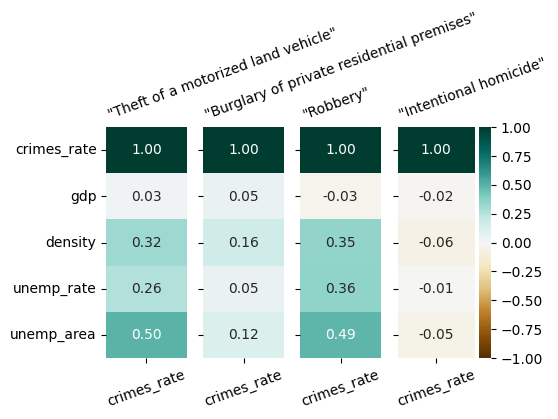

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(5, 3), gridspec_kw={'width_ratios': [1, 1, 1, 1.2]})
i=0
j=0
g=3
for iccs in subset['iccs'].unique():
    g_bin = bin(g)[2:]
    i = g_bin[-1]
    if len(g_bin) < 2:
        j = 0
    else:
        j = g_bin[-2]
    #print(f"i = {i}, j = {j}")
        
    us1 = subset[subset['iccs'] ==  iccs]
    corr = us1[['crimes_rate', 'gdp', 'density', 'unemp_rate', 'unemp_area']].corr()
    #corr = us1[['crimes_rate']].corr()
    #sns.heatmap(corr[['crimes_rate']], vmin=-1, vmax=1, annot=True, fmt=".2f", cmap='BrBG', ax=axs[int(i),int(j)])
    
    if g == 3:
        sns.heatmap(corr[['crimes_rate']], vmin=-1, vmax=1, annot=True, fmt=".2f", cmap='BrBG', ax=axs[g], cbar=True)
        axs[\
        #int(i),int(j)
        g].set_yticklabels([])
    elif g == 0:
        print(axs[g].get_xlim())
        sns.heatmap(corr[['crimes_rate']], vmin=-1, vmax=1, annot=True, fmt=".2f", cmap='BrBG', ax=axs[g], cbar=False)
        #axs[g].set_xlim(0, 1.2)
    else:
        sns.heatmap(corr[['crimes_rate']], vmin=-1, vmax=1, annot=True, fmt=".2f", cmap='BrBG', ax=axs[g], cbar=False)
        #axs[g].set_xlim(0, 1.2)
        axs[\
        #int(i),int(j)
        g].set_yticklabels([])
    axs[g].set_title(f'"{us1["iccs_d"].unique()[0]}"', fontsize=10, loc='left', rotation=20)  
    axs[g].tick_params(axis='x', labelrotation=20) 
    g=g-1

#plt.tight_layout()
#plot.heatmap(vmin=-1, vmax=1, annot=True, fmt=".2f", cmap='BrBG', ax=axs[int(i),int(j)], cbar=True)
plt.savefig(f"../plots/heatmap_small.png", bbox_inches='tight')
plt.show()
    



(0.0, 1.0)


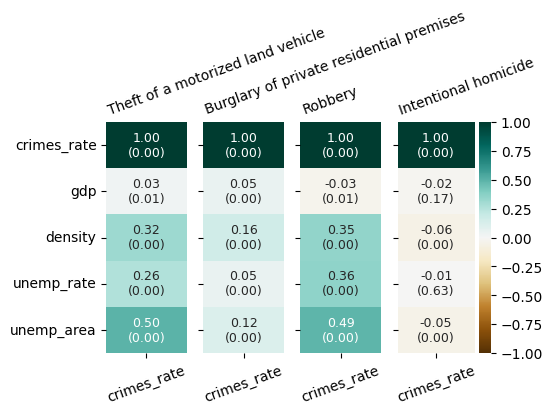

[-21608.96657627] 159954.70901597088


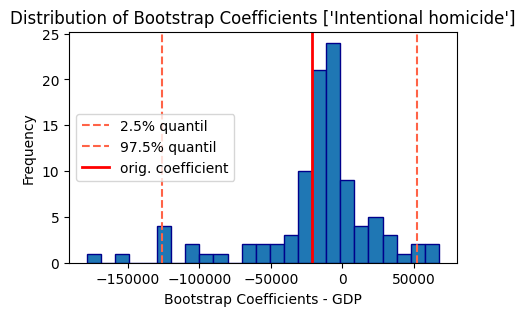

[-21.86790899] 344.3990566536406


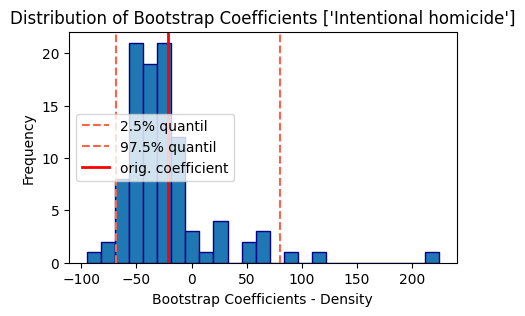

[-0.01387409] 3.746872415762891


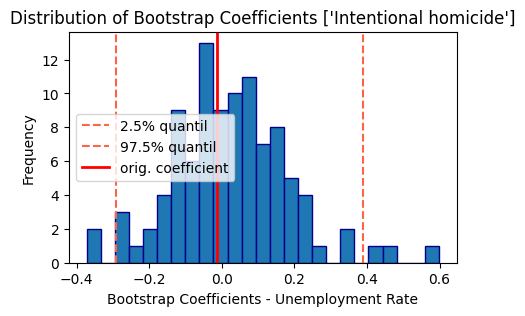

[-90.89564101] 1263.8853039250373


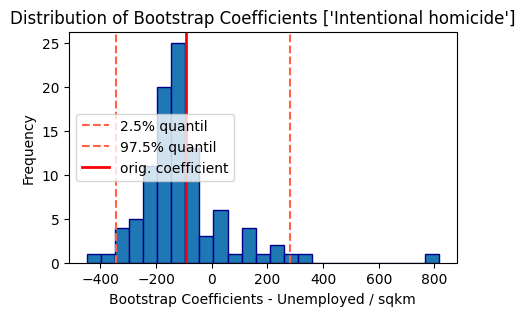

[-864.59847627] 179617.75577404498


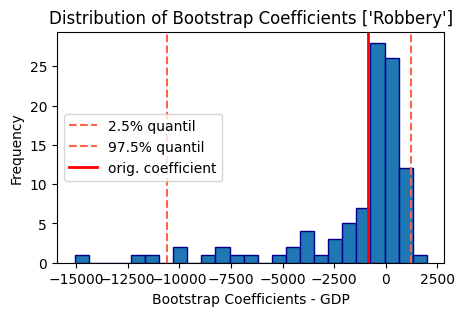

[3.00827895] 182.3738041420595


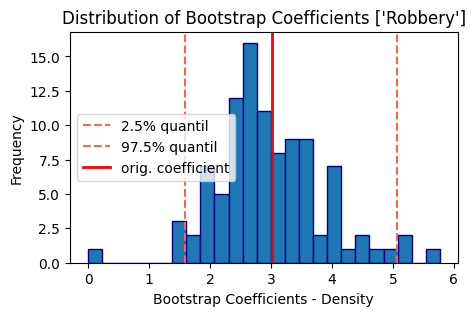

[0.01728411] 2.653325217095415


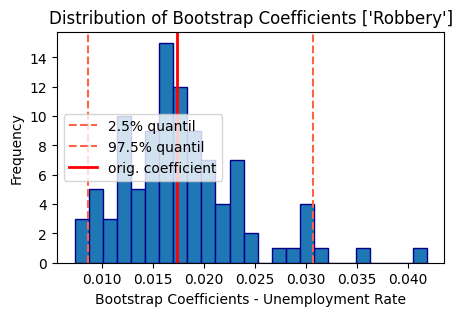

[19.29988123] 146.05579314241766


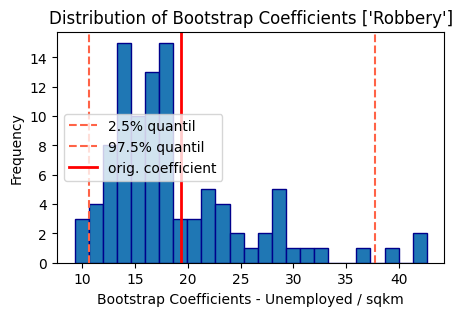

[119.83074055] 64690.44390414649


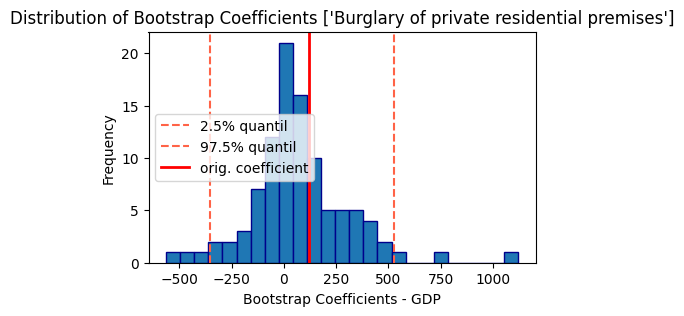

[0.44342132] 262.26861053866594


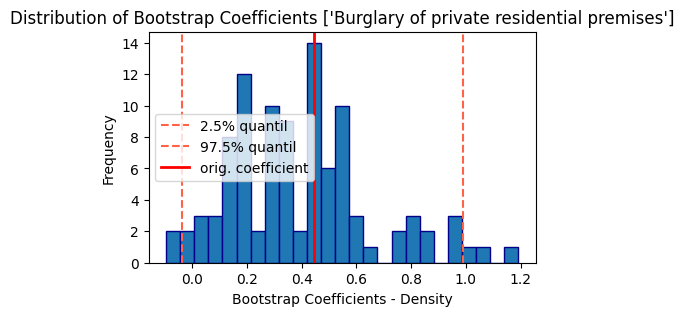

[0.00079262] 3.4921243720702773


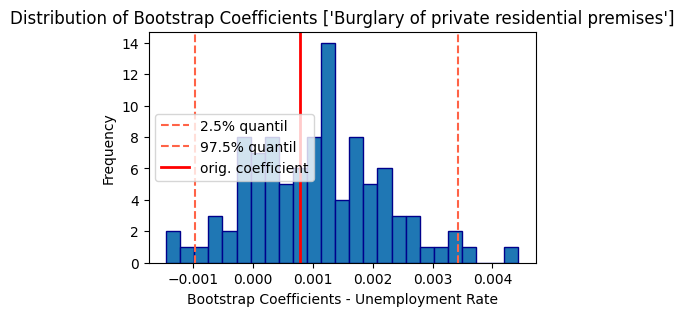

[1.50967817] 910.7213251477838


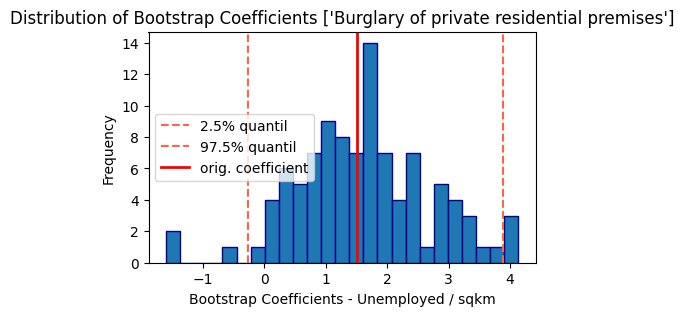

[102.57018463] 76784.39462574478


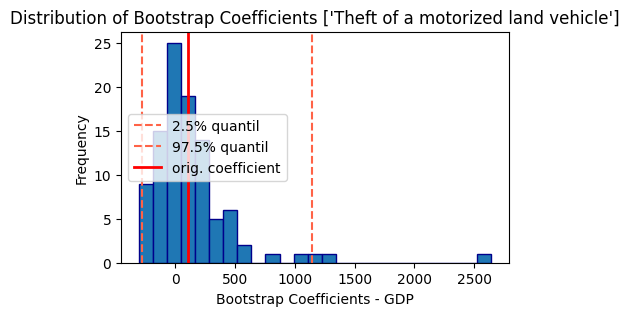

[1.30033365] 242.87200414165864


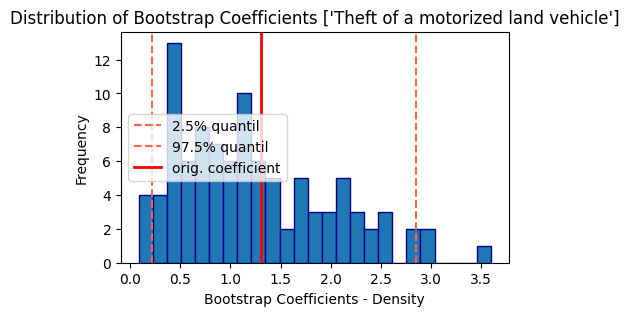

[0.00583744] 3.0178296086896763


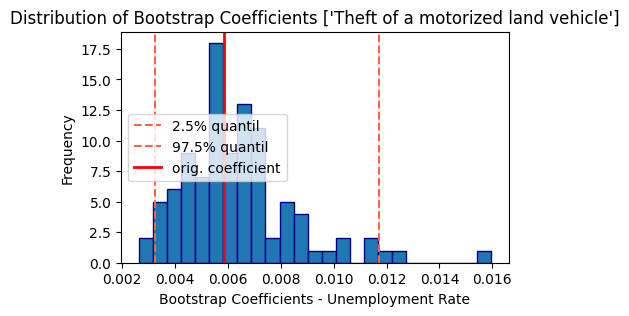

[9.01376547] 423.0218372145165


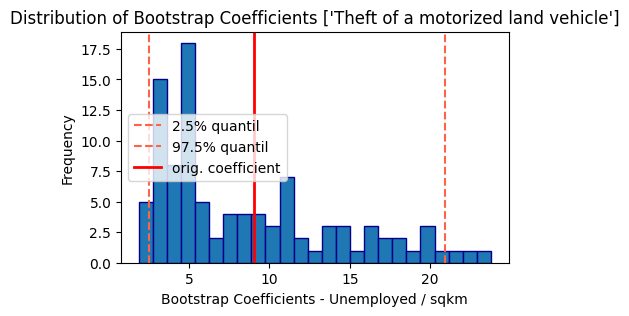

In [212]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(5, 3), gridspec_kw={'width_ratios': [1, 1, 1, 1.2]})
i=0
j=0
g=3
for iccs in subset['iccs'].unique():
    g_bin = bin(g)[2:]
    i = g_bin[-1]
    if len(g_bin) < 2:
        j = 0
    else:
        j = g_bin[-2]
    #print(f"i = {i}, j = {j}")
        
    us1 = subset[subset['iccs'] ==  iccs]
    corr = us1[['crimes_rate', 'gdp', 'density', 'unemp_rate', 'unemp_area']].corr(method='pearson')
    #print(corr)
    p_values = us1[['crimes_rate', 'gdp', 'density', 'unemp_rate', 'unemp_area']].corr(method=lambda x, y: stats.pearsonr(x, y)[1]) - np.eye(*corr.shape)
    #corr = us1[['crimes_rate']].corr()
    #sns.heatmap(corr[['crimes_rate']], vmin=-1, vmax=1, annot=True, fmt=".2f", cmap='BrBG', ax=axs[int(i),int(j)])
    
    if g == 3:
        sns.heatmap(corr[['crimes_rate']], vmin=-1, vmax=1, annot=True, fmt=".2f", cmap='BrBG', ax=axs[g], cbar=True)
        axs[\
        #int(i),int(j)
        g].set_yticklabels([])
    elif g == 0:
        print(axs[g].get_xlim())
        sns.heatmap(corr[['crimes_rate']], vmin=-1, vmax=1, annot=True, fmt=".2f", cmap='BrBG', ax=axs[g], cbar=False)
        #axs[g].set_xlim(0, 1.2)
    else:
        sns.heatmap(corr[['crimes_rate']], vmin=-1, vmax=1, annot=True, fmt=".2f", cmap='BrBG', ax=axs[g], cbar=False)
        #axs[g].set_xlim(0, 1.2)
        axs[\
        #int(i),int(j)
        g].set_yticklabels([])
    axs[g].set_title(f'{us1["iccs_d"].unique()[0]}', fontsize=10, loc='left', rotation=20)  
    axs[g].tick_params(axis='x', labelrotation=20)
    ti = 0
    for text in axs[g].texts:
        #print(p_values[['crimes_rate']].iloc[ti,0])
        text.set_size(9)
        text.set_text(f"{text.get_text()}\n({p_values[['crimes_rate']].iloc[ti,0]:.2f})")
        ti=ti+1
    g=g-1

#plt.tight_layout()
#plot.heatmap(vmin=-1, vmax=1, annot=True, fmt=".2f", cmap='BrBG', ax=axs[int(i),int(j)], cbar=True)
plt.savefig(f"../plots/heatmap_small.png", bbox_inches='tight')
plt.show()

for iccs in subset['iccs'].unique():
    us1 = subset[subset['iccs'] ==  iccs]

    model=LinearRegression().fit(us1[["crimes_rate"]],us1["gdp"])
    print(model.coef_, model.intercept_)
    
    multi_sample_bs_model_coef = []
    for i in range(100):
        sampled_users = us1.sample(100, replace=True)
        multi_sample_bs_model = LinearRegression()
        multi_sample_bs_model.fit(sampled_users[["crimes_rate"]], sampled_users["gdp"])
        multi_sample_bs_model_coef.append(multi_sample_bs_model.coef_[0])
    multi_sample_bs_model_coef = np.array(multi_sample_bs_model_coef) # Convert to array for simpler use later
    confidence_interval = np.percentile(multi_sample_bs_model_coef, [2.5, 97.5])
    fig, ax = plt.subplots(1, 1,  figsize=(5,3))
    ax.hist(multi_sample_bs_model_coef, bins=25, edgecolor='darkblue') 
    ax.set_title(f"Distribution of Bootstrap Coefficients {us1['iccs_d'].unique()}")
    ax.set_xlabel("Bootstrap Coefficients - GDP")
    ax.set_ylabel("Frequency")
    ax.axvline(confidence_interval[0], color="tomato", linestyle='dashed', label='2.5% quantil')
    ax.axvline(confidence_interval[1], color="tomato", linestyle='dashed', label='97.5% quantil')
    ax.axvline(model.coef_, color="red", linewidth=2, label='orig. coefficient')
    ax.legend(loc=6)
    plt.savefig(f"../plots/bootstrap_gdp_{iccs}.png", bbox_inches='tight')
    plt.show()

    model=LinearRegression().fit(us1[["crimes_rate"]],us1["density"])
    print(model.coef_, model.intercept_)
    
    multi_sample_bs_model_coef = []
    for i in range(100):
        sampled_users = us1.sample(100, replace=True)
        multi_sample_bs_model = LinearRegression()
        multi_sample_bs_model.fit(sampled_users[["crimes_rate"]], sampled_users["density"])
        multi_sample_bs_model_coef.append(multi_sample_bs_model.coef_[0])
    multi_sample_bs_model_coef = np.array(multi_sample_bs_model_coef) # Convert to array for simpler use later
    confidence_interval = np.percentile(multi_sample_bs_model_coef, [2.5, 97.5])
    fig, ax = plt.subplots(1, 1,  figsize=(5,3))
    ax.hist(multi_sample_bs_model_coef, bins=25, edgecolor='darkblue') 
    ax.set_title(f"Distribution of Bootstrap Coefficients {us1['iccs_d'].unique()}")
    ax.set_xlabel("Bootstrap Coefficients - Density")
    ax.set_ylabel("Frequency")
    ax.axvline(confidence_interval[0], color="tomato", linestyle='dashed', label='2.5% quantil')
    ax.axvline(confidence_interval[1], color="tomato", linestyle='dashed', label='97.5% quantil')
    ax.axvline(model.coef_, color="red", linewidth=2, label='orig. coefficient')
    ax.legend(loc=6)
    plt.savefig(f"../plots/bootstrap_density_{iccs}.png", bbox_inches='tight')
    plt.show()
    model=LinearRegression().fit(us1[["crimes_rate"]],us1["unemp_rate"])
    print(model.coef_, model.intercept_)
    
    multi_sample_bs_model_coef = []
    for i in range(100):
        sampled_users = us1.sample(100, replace=True)
        multi_sample_bs_model = LinearRegression()
        multi_sample_bs_model.fit(sampled_users[["crimes_rate"]], sampled_users["unemp_rate"])
        multi_sample_bs_model_coef.append(multi_sample_bs_model.coef_[0])
    multi_sample_bs_model_coef = np.array(multi_sample_bs_model_coef) # Convert to array for simpler use later
    confidence_interval = np.percentile(multi_sample_bs_model_coef, [2.5, 97.5])
    fig, ax = plt.subplots(1, 1,  figsize=(5,3))
    ax.hist(multi_sample_bs_model_coef, bins=25, edgecolor='darkblue') 
    ax.set_title(f"Distribution of Bootstrap Coefficients {us1['iccs_d'].unique()}")
    ax.set_xlabel("Bootstrap Coefficients - Unemployment Rate")
    ax.set_ylabel("Frequency")
    ax.axvline(confidence_interval[0], color="tomato", linestyle='dashed', label='2.5% quantil')
    ax.axvline(confidence_interval[1], color="tomato", linestyle='dashed', label='97.5% quantil')
    ax.axvline(model.coef_, color="red", linewidth=2, label='orig. coefficient')
    ax.legend(loc=6)
    plt.savefig(f"../plots/bootstrap_unemp_rate_{iccs}.png", bbox_inches='tight')
    plt.show()
    model=LinearRegression().fit(us1[["crimes_rate"]],us1["unemp_area"])
    print(model.coef_, model.intercept_)
    
    multi_sample_bs_model_coef = []
    for i in range(100):
        sampled_users = us1.sample(100, replace=True)
        multi_sample_bs_model = LinearRegression()
        multi_sample_bs_model.fit(sampled_users[["crimes_rate"]], sampled_users["unemp_area"])
        multi_sample_bs_model_coef.append(multi_sample_bs_model.coef_[0])
    multi_sample_bs_model_coef = np.array(multi_sample_bs_model_coef) # Convert to array for simpler use later
    confidence_interval = np.percentile(multi_sample_bs_model_coef, [2.5, 97.5])
    fig, ax = plt.subplots(1, 1,  figsize=(5,3))
    ax.hist(multi_sample_bs_model_coef, bins=25, edgecolor='darkblue') 
    ax.set_title(f"Distribution of Bootstrap Coefficients {us1['iccs_d'].unique()}")
    ax.set_xlabel("Bootstrap Coefficients - Unemployed / sqkm")
    ax.set_ylabel("Frequency")
    ax.axvline(confidence_interval[0], color="tomato", linestyle='dashed', label='2.5% quantil')
    ax.axvline(confidence_interval[1], color="tomato", linestyle='dashed', label='97.5% quantil')
    ax.axvline(model.coef_, color="red", linewidth=2, label='orig. coefficient')
    ax.legend(loc=6)
    plt.savefig(f"../plots/bootstrap_unemp_area_{iccs}.png", bbox_inches='tight')
    plt.show()

In [7]:
print(dfout['iccs'].unique(), dfout['iccs_d'].unique())
#dfplot = dfout[dfout['metroreg'].str.startswith('AT')]
#dfout = dfout[dfout['iccs'].str.startswith('ICCS0401')]
#dfplot

['ICCS0101' 'ICCS0401' 'ICCS05012' 'ICCS050211'] ['Intentional homicide' 'Robbery'
 'Burglary of private residential premises'
 'Theft of a motorized land vehicle']


[-0.00502867] 56.296128704733846
PearsonRResult(statistic=-0.05130255169563649, pvalue=6.759174805454918e-05)
TtestResult(statistic=42.46046756362984, pvalue=0.0, df=12052.0)


AttributeError: 'LinearRegression' object has no attribute 'data'

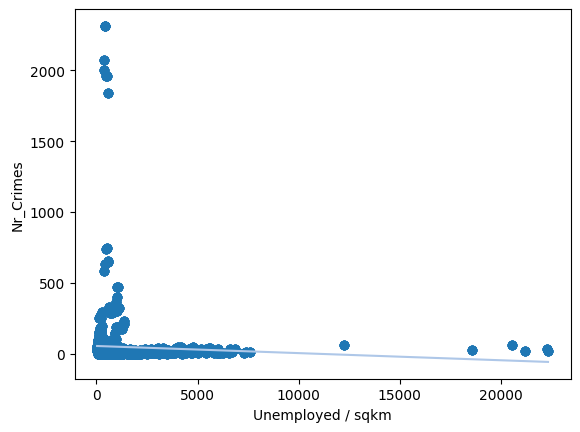

In [9]:
        #corr = uset[['unemp_area', 'unemp per Tsd.', 'population',  'area', 'gdp', 'density', 'unemp_rate', 'crimes_rate Nr_Crimes']].corr()

# Create a list of colors from the Set2 colormap
colors = plt.cm.tab20(range(len(dfout['iccs_d'].unique())*2))

# Create a scatter plot with custom colors
subset = dfout[dfout['dfunemp_sex'] == 'T:Total'] 

for i, iccs in enumerate(dfout['iccs_d'].unique()):
    fig, ax1 = plt.subplots()
    uset = subset[subset['iccs_d'] == iccs]

    model=LinearRegression().fit(uset[["unemp_area"]],uset["Nr_Crimes"])
    print(model.coef_, model.intercept_)
    print(stats.pearsonr(uset['unemp_area'],uset['Nr_Crimes']))
    print(f"{stats.ttest_ind(uset['unemp_area'],uset['Nr_Crimes'])}")
    ax1.scatter(uset['unemp_area'], uset['Nr_Crimes'], color=colors[i*2], label=iccs)
    x_min = uset["unemp_area"].min()
    x_max = uset["unemp_area"].max()
    x_reg = np.linspace(x_min, x_max)
    y_reg = model.coef_ * x_reg + model.intercept_
    ax1.plot(x_reg,y_reg,color=colors[i*2+1])
    ax1.set_xlabel('Unemployed / sqkm')
    ax1.set_ylabel('Nr_Crimes')

    plt.title('')
    fig.legend(loc=5)
    plt.savefig(f"../plots/{iccs}_No_crimes_unemp_sqkm.png")
    plt.show()

    
x = subset['Nr_Crimes']
y = subset['density']
m, b = np.polyfit(x, y, 1)

# Plot the regression line
#plt.plot(x, m*x + b, color='black')


[-2.78609293e-05] 1.1282549195232123
PearsonRResult(statistic=-0.05032332488632177, pvalue=9.28883595114024e-05)
TtestResult(statistic=44.55405873160667, pvalue=0.0, df=12052.0)


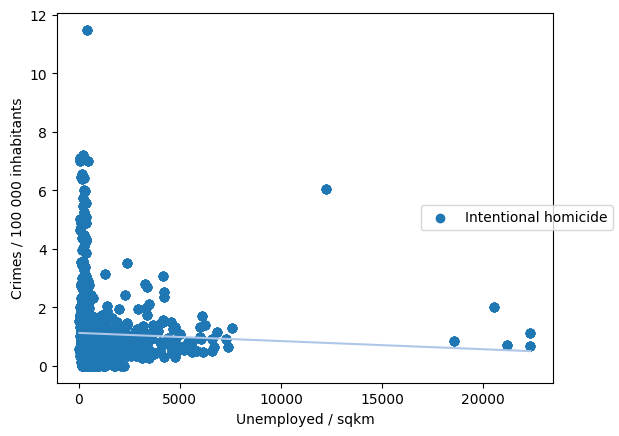

[0.01243767] 36.225615626521396
PearsonRResult(statistic=0.48994437743481595, pvalue=0.0)
TtestResult(statistic=46.5950817312753, pvalue=0.0, df=14362.0)


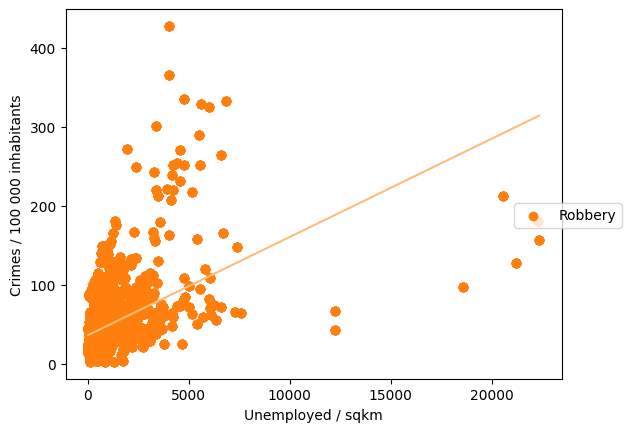

[0.00878576] 187.471249815684
PearsonRResult(statistic=0.11516798476350835, pvalue=8.75532309441277e-20)
TtestResult(statistic=39.486011465751865, pvalue=0.0, df=12416.0)


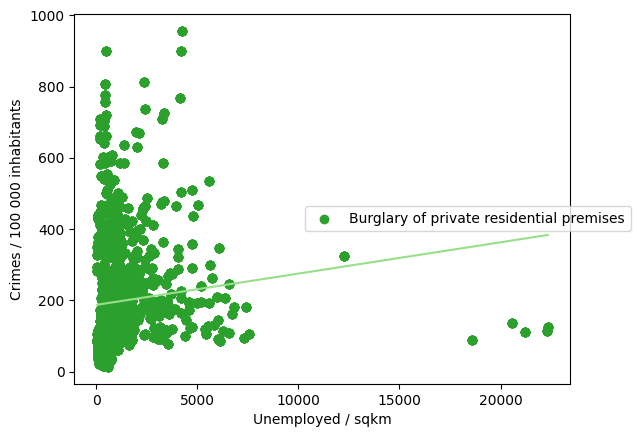

[0.02719784] 48.55341772160033
PearsonRResult(statistic=0.49513120961834106, pvalue=0.0)
TtestResult(statistic=47.25198969019188, pvalue=0.0, df=14516.0)


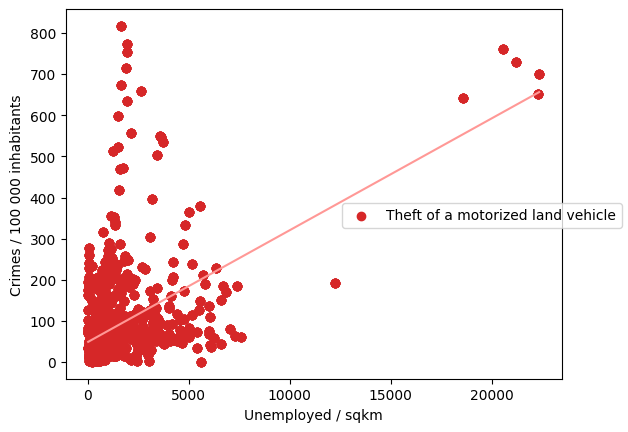

In [28]:
        #corr = uset[['unemp_area', 'unemp per Tsd.', 'population',  'area', 'gdp', 'density', 'unemp_rate', 'crimes_rate Nr_Crimes']].corr()

# Create a list of colors from the Set2 colormap
colors = plt.cm.tab20(range(len(dfout['iccs_d'].unique())*2))

# Create a scatter plot with custom colors
subset = dfout[dfout['dfunemp_sex'] == 'T:Total'] 

for i, iccs in enumerate(dfout['iccs_d'].unique()):
    fig, ax1 = plt.subplots()
    uset = subset[subset['iccs_d'] == iccs]

    model=LinearRegression().fit(uset[["unemp_area"]],uset["crimes_rate"])
    print(model.coef_, model.intercept_)
    print(stats.pearsonr(uset['unemp_area'],uset['crimes_rate']))
    print(f"{stats.ttest_ind(uset['unemp_area'],uset['crimes_rate'])}")
    ax1.scatter(uset['unemp_area'], uset['crimes_rate'], color=colors[i*2], label=iccs)
    x_min = uset["unemp_area"].min()
    x_max = uset["unemp_area"].max()
    x_reg = np.linspace(x_min, x_max)
    y_reg = model.coef_ * x_reg + model.intercept_
    ax1.plot(x_reg,y_reg,color=colors[i*2+1])
    ax1.set_xlabel('Unemployed / sqkm')
    ax1.set_ylabel('Crimes / 100 000 inhabitants')

    plt.title('')
    fig.legend(loc=5)
    plt.savefig(f"../plots/{iccs}_crimes_rate_unemp_sqkm.png")
    plt.show()

    
x = subset['Nr_Crimes']
y = subset['density']
m, b = np.polyfit(x, y, 1)

# Plot the regression line
#plt.plot(x, m*x + b, color='black')


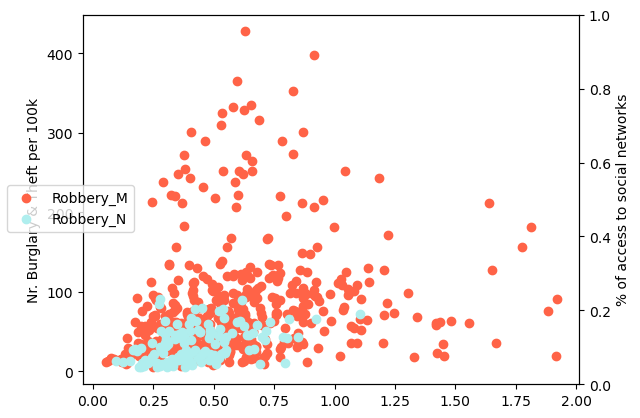

[0.00127723] 0.45733103860269464
[0.00107436] 0.48950086637050155
[0.00338794] 0.3170239647693083
PearsonRResult(statistic=0.23324774132487158, pvalue=6.247928448764454e-08)
PearsonRResult(statistic=0.41066749434909683, pvalue=1.6225672082965782e-06)
crime rate vs youth unemp rate: TtestResult(statistic=25.794484349329483, pvalue=4.8385168441069574e-114, df=1050.0)
crime rate vs youth unemp rate: TtestResult(statistic=17.61737258395607, pvalue=7.980006607864445e-46, df=252.0)


In [108]:
dfout2 = dfout[dfout['metroreg_type']=='N']
#print(dfout2)
dfout1 = dfout[dfout['metroreg_type']=='M']
#dfplot = dfout[dfout['metroreg'].str.startswith('AT')]
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
#ax1.scatter(dfout['TIME_PERIOD'], dfout['dfcrimes_rate_all'], color='tomato', label='Burglaries and Thefts')
ax1.scatter(dfout1['dfunemp_rate_youth'], dfout1['dfcrimes_rate_all'], color='tomato', label=max(dfout1['iccs_d'])+'_M')
ax1.scatter(dfout2['dfunemp_rate_youth'], dfout2['dfcrimes_rate_all'], color='paleturquoise', label=max(dfout2['iccs_d'])+'_N')
#ax1.plot(dfout3['TIME_PERIOD'], dfout3['Nr_Crimes'], color='moccasin', label=max(dfout3['iccs_d']))
#ax1.plot(dfout4['TIME_PERIOD'], dfout4['Nr_Crimes'], color='deepskyblue', label=max(dfout4['iccs_d']))
#plt.plot(df[df['name'] == 'John']['age'], label='John')
#ax2.plot(dfout['TIME_PERIOD'], dfout['socnet'], color='lightgreen', label='% attending social networks')
#ax2.plot(dfout1['TIME_PERIOD'], dfout1['dfunemp_rate_youth'], color='lightgreen', label='unemployment rate')
#ax2.scatter(dfout['TIME_PERIOD'], dfout['gini'], color='darkgoldenrod', label='Gini-Index')

#ax1.set_title('Scatter Plot with Two Lines')
#ax1.set_xlabel('X-axis')
ax1.set_ylabel('Nr. Burglary & Theft per 100k')
ax2.set_ylabel('% of access to social networks')

plt.title('')
#plt.ylabel('GDP per capita')
fig.legend(loc=6)
plt.show()


model = LinearRegression().fit(dfout[["dfcrimes_rate_all"]],dfout["dfunemp_rate_youth"]) # Enter the data for the linear regression model
print(model.coef_, model.intercept_)
model = LinearRegression().fit(dfout1[["dfcrimes_rate_all"]],dfout1["dfunemp_rate_youth"]) # Enter the data for the linear regression model
print(model.coef_, model.intercept_)
model = LinearRegression().fit(dfout2[["dfcrimes_rate_all"]],dfout2["dfunemp_rate_youth"]) # Enter the data for the linear regression model
print(model.coef_, model.intercept_)

print(stats.pearsonr(dfout1['dfcrimes_rate_all'],dfout1['dfunemp_rate_youth']))
print(stats.pearsonr(dfout2['dfcrimes_rate_all'],dfout2['dfunemp_rate_youth']))
print(f"crime rate vs youth unemp rate: {stats.ttest_ind(dfout1['dfcrimes_rate_all'],dfout1['dfunemp_rate_youth'])}")
print(f"crime rate vs youth unemp rate: {stats.ttest_ind(dfout2['dfcrimes_rate_all'],dfout2['dfunemp_rate_youth'])}")

C:\Users\zmugm1\AppData\Local\Temp\ipykernel_7744\79973963.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfout2["SI"]  = dfout2["dfcrimes_rate_all"].apply(lambda x: np.log(x))
C:\Users\zmugm1\AppData\Local\Temp\ipykernel_7744\79973963.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfout2["FC"] = dfout2["dfunemp_rate_youth"].apply(lambda x: np.log(x))


[0.78694847] 4.014664472909605


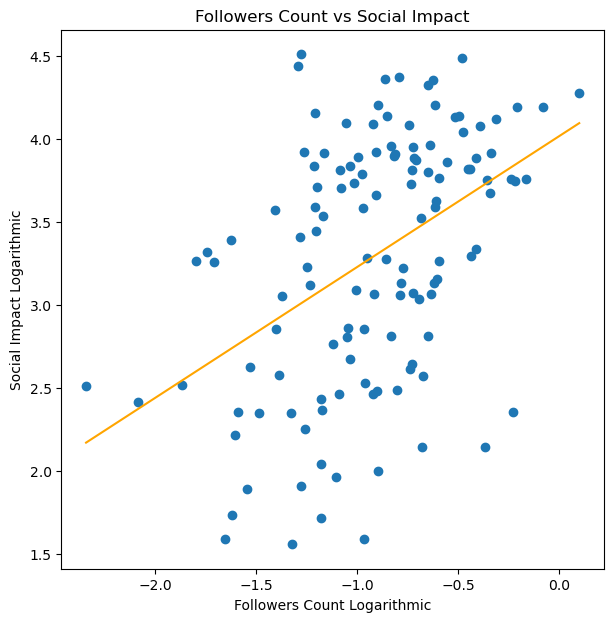

In [111]:
dfout2["SI"]  = dfout2["dfcrimes_rate_all"].apply(lambda x: np.log(x))
dfout2["FC"] = dfout2["dfunemp_rate_youth"].apply(lambda x: np.log(x))

model = LinearRegression().fit(dfout2[["FC"]],dfout2["SI"]) # Enter the data for the linear regression model
print(model.coef_, model.intercept_)

fig, ax = plt.subplots(1, 1,  figsize=(7,7))
ax.scatter(dfout2["FC"],dfout2["SI"]) # Enter the data for the scatter plot
ax.set_title("Followers Count vs Social Impact")
ax.set_xlabel("Followers Count Logarithmic")
ax.set_ylabel("Social Impact Logarithmic")
# add the linear regression line
x_min = dfout2["FC"].min()
x_max = dfout2["FC"].max()
# version with intercept and coef:
x_reg = np.linspace(x_min, x_max)
y_reg = model.coef_ * x_reg + model.intercept_
ax.plot(x_reg,y_reg,color='orange') # Enter the data for the linear regression line
plt.show()

In [96]:
dfgini = pd.read_csv("../raw_data/Unemployment_met_lfu3pers_linear.csv")
#dfgini = pd.read_csv("../raw_data/ICT_Usage_isoc_ci_ac_i_linear.csv")
#dfgini = pd.read_csv("../raw_data/Crime_in_Metropoles_estat_met_crim_gen_en.csv")
#dfgini[['geo', 'geo_d']] = dfgini['geo'].str.split(':', expand=True)
dfgini = dfgini[dfgini['metroreg'].str.startswith('DE')]
#dfgini = dfgini[dfgini['iccs'].str.startswith('ICCS050211')]
#dfgini = dfgini.loc[dfgini['TIME_PERIOD'] > 2015]
    #dfgini = dfgini.loc[dfgini['TIME_PERIOD'] == 2015 ]
#dfgini.dropna(subset=['OBS_VALUE'], inplace=True)

print(dfgini.dtypes)
print(dfgini['sex'].unique())
print(dfgini['age'].unique())
#dfgini

DATAFLOW        object
LAST UPDATE     object
freq            object
unit            object
age             object
sex             object
metroreg        object
TIME_PERIOD      int64
OBS_VALUE      float64
OBS_FLAG        object
dtype: object
['F:Females' 'M:Males' 'T:Total']
['Y15-24:From 15 to 24 years' 'Y15-29:From 15 to 29 years'
 'Y15-74:From 15 to 74 years' 'Y20-64:From 20 to 64 years'
 'Y_GE15:15 years or over' 'Y_GE25:25 years or over']


In [10]:

def normalize1(df, column_name='geo'):
    delimiter = ":"
    new_column_names = [column_name, column_name + '_d']
    #print(new_column_names,'//',delimiter,'//',column_name)
    df[new_column_names] = df[column_name].str.split(delimiter, expand=True)
    
    #df.dropna(subset=['OBS_VALUE'], inplace=True)
    return df

def grouping1(df, rename='value', agg='mean'):
    #print(df, rename, agg, cols_to_groupby)
    #df.dropna(subset=['OBS_VALUE'], inplace=True)
    #exec(f"df = df.groupby(['metroreg', {add}]).agg({{'OBS_VALUE': {agg}}})")
    cols_to_groupby=['geo', 'TIME_PERIOD']
    df = df.groupby(cols_to_groupby).agg({'OBS_VALUE': agg}) ##, 'geo_d': 'max'})
    df.rename(columns={'TIME_PERIOD': 'year'}, inplace=True)
    df.rename(columns={'OBS_VALUE': rename}, inplace=True)
    df = df.reset_index()
    return df


tablelist = [\
          ('dfalc_b','d_alc',"../raw_data/Archive/Death_to_alcoholic_abuse_tps00140_linear.csv",'mean'), \
           ('dfgini_b','gini',"../raw_data/Archive/Gini_index_tessi190_linear.csv",'mean'), \
           ('dfhealthage_b','h_age',"../raw_data/Archive/Healthy_life_years_hlth_hlye_linear.csv",'mean'), \
           ('dfsocnet_b','socnet',"../raw_data/Archive/Participation_in_social_networks_testat_tin00127_en.csv",'mean'), \
           #('dfcrime','dfcrime',"Crimes_per_100tsd_estat_crim_off_cat_en.csv"),
           ('dfpoverty_b','poverty',"../raw_data/Archive/People_risk_poverty_or_social_exclusion_sdg_01_10_linear.csv",'mean'), \
           ('dfunemp_b','unemp',"../raw_data/Archive/Unemployment_rate_tipsun20_linear.csv",'mean')]

#Nachschauen worauf sich d_alc der Wert bezieht!!!!
## Wie wird poverty das gemessen?????
for dataframe, name, value, agg in tablelist:
    exec(f"{dataframe} = pd.read_csv('{value}')")
    #exec(f"print('{dataframe}', len({dataframe}) )")   
    #exec(f"print({dataframe})")

dfalc_b  = dfalc_b.loc[dfalc_b ['sex'] == 'T:Total']
dfhealthage_b = dfhealthage_b.loc[dfhealthage_b ['sex'] == 'T:Total']
dfhealthage_b = dfhealthage_b[dfhealthage_b['indic_he'].str.startswith('HLY_PC_0')]
dfpoverty_b   = dfpoverty_b[dfpoverty_b['age'].str.startswith('TOTAL:Total')]
dfpoverty_b   = dfpoverty_b[dfpoverty_b['unit'].str.startswith('PC:Percentage')]                      
dfunemp_b     = dfunemp_b[dfunemp_b['unit'].str.startswith('PC_ACT')]     
dfunemp_b     = dfunemp_b[dfunemp_b['age'].str.startswith('Y25-74')]

#for dataframe, name, value, agg in tablelist:
#    exec(f"print('{dataframe}', len({dataframe}) )")   

dfall_b = dfalc_b
dfall_b = dfall_b.reset_index()
dfall_b.drop(columns=dfall_b.columns.difference(['geo', 'TIME_PERIOD']), axis=1, inplace=True)
#print(dfall_b)

for dataframe, name, value, agg in tablelist:
    exec(f"{dataframe} = grouping1({dataframe}, '{name}', '{agg}')")
    exec(f"dfall_b = pd.merge(dfall_b, {dataframe}, on=['geo', 'TIME_PERIOD'], how='outer')")

dfcrime1 = pd.read_csv("../raw_data/Archive/Crimes_per_100tsd_estat_crim_off_cat_en.csv")
dfcrime1.rename(columns={'OBS_VALUE': 'Nr_Crimes'}, inplace=True)
dfcrime1 = dfcrime1[dfcrime1['unit'].str.startswith('P_HTHAB')]
#dfcrime = dfcrime[dfcrime['iccs'].str.startswith('ICCS0101')\
                  #|dfcrime['iccs'].str.startswith('ICCS03')\
#                 ]
#dfcrime = dfcrime.groupby(['geo', 'TIME_PERIOD'])['Nr_Crimes'].sum()
dfcrime1 = dfcrime1.groupby(['geo', 'TIME_PERIOD', 'iccs'])['Nr_Crimes'].sum()
dfcrime1 = dfcrime1.reset_index()
dfcrime1 = normalize1(dfcrime1)
dfcrime1.drop('geo_d', axis=1, inplace=True)
dfcrime1 = normalize1(dfcrime1,'iccs')

dfall_b = normalize1(dfall_b)
dfall_b = pd.merge(dfall_b, dfcrime1, on=['geo', 'TIME_PERIOD'], how='inner')
dfall_b.to_csv('../data/df_all.csv', index=False)

#print(dfall_b)

#print(dfcrime['iccs'].unique())

In [8]:
dfout_b = dfall_b
print(dfout_b['iccs'].unique(), dfout_b['iccs_d'].unique())
dfout_b.dropna(subset=['socnet'], inplace=True)
dfout_b.dropna(subset=['Nr_Crimes'], inplace=True)
#dfout_b.dropna(subset=['gini'], inplace=True)
dfout_b = dfout_b.loc[dfout_b['TIME_PERIOD'] < 2020]
dfout_b = dfout_b[dfout_b['iccs'].str.startswith('ICCS05')\
                  #|dfout_b['iccs'].str.startswith('ICCS03')\
                 ]
#dfout_b = dfout_b.groupby(['geo', 'TIME_PERIOD'])[['Nr_Crimes'],['gini']].sum()
dfout_b = dfout_b.groupby([#'geo', 
                       'TIME_PERIOD' 
                       #, 'iccs' , 'iccs_d'
                        ]).agg({  'Nr_Crimes': 'mean'#})
                                            , 'gini'     : 'mean'
                                            , 'socnet'   : 'mean'
                                            , 'unemp'   : 'mean'
                                            })
dfout_b = dfout_b.reset_index()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(dfout_b['TIME_PERIOD'], dfout_b['Nr_Crimes'], color='tomato', label='Burglaries and Thefts')
ax2.plot(dfout_b['TIME_PERIOD'], dfout_b['socnet'], color='lightgreen', label='% attending social networks')
#ax1.set_xlabel('X-axis')
ax1.set_ylabel('Nr. Burglary & Theft per 100k')
ax2.set_ylabel('% of access to social networks')

plt.title('')
#plt.ylabel('GDP per capita')
fig.legend(loc=6)
plt.savefig(f"../plots/Archive_Burglary_Theft_Soc_Net.png")
plt.show()


model = LinearRegression().fit(dfout_b[["Nr_Crimes"]],dfout_b["socnet"]) # Enter the data for the linear regression model
print(model.coef_, model.intercept_)

#ICCS0903
#die Tabelle data/new.csv enthält die Daten bisher (ich muss noch die neuen Faktoren hinzufügen, aber ein paar sind schon drin). 
#Könntet ihr ein paar Plots zur Verteilung der Daten machen?
#Die Spalten GINI_HND,I_IUSNET,F10_RT sind die Faktoren. Alle anderen Spalten sind die verschiedenen Verbrechen, jeweils in absolut und normiert. Ich würde die normierten nehemen, die Spalten haben jeweils die Endung _P_HTHAB, also z.B. ICCS05021_P_HTHAB.
#Intentional homicide könnte interessant sein, das wäre crime code ICCS0101. 

print(model.coef_, model.intercept_) 
print(model.get_params())
prediction = model.predict(dfout_b[["Nr_Crimes"]]) # Predict the social impact
residual = dfout_b["socnet"] - prediction # Calculate the residual
print(np.var(residual))
print(np.var(dfout_b["socnet"]))
print(1 - np.var(residual) / np.var(dfout_b["socnet"])) 

pearson_soc_burglary = stats.pearsonr(dfout_b['Nr_Crimes'],dfout_b['socnet'])
print(pearson_soc_burglary)
print(f"Burglary/Theft vs access to soc. networks: {stats.ttest_ind(dfout_b['Nr_Crimes'],dfout_b['socnet'])}")

colors = plt.cm.tab20(range(len(dfall_b['iccs_d'].unique())*2))
for i, iccs in enumerate(dfall_b['iccs_d'].unique()):
    fig, ax1 = plt.subplots()
    uset = dfall_b[dfall_b['iccs_d'] == iccs]

    model=LinearRegression().fit(uset[["socnet"]],uset["Nr_Crimes"])
    print(model.coef_, model.intercept_)
    print(stats.pearsonr(uset['socnet'],uset['Nr_Crimes']))
    print(f"{stats.ttest_ind(uset['socnet'],uset['Nr_Crimes'])}")

    ax1.scatter(uset['socnet'], uset['Nr_Crimes'], color=colors[i*2], label=iccs)
    x_min = uset["socnet"].min()
    x_max = uset["socnet"].max()
    x_reg = np.linspace(x_min, x_max)
    y_reg = model.coef_ * x_reg + model.intercept_
    ax1.plot(x_reg,y_reg,color=colors[i*2+1])
    ax1.set_xlabel('% use soc. networks')
    ax1.set_ylabel('Nr. of Crimes')

    plt.title('')
    fig.legend(loc=5)
    plt.savefig(f"../plots/Archive/{iccs}_{var}_soc_net.png")
    plt.show()

NameError: name 'dfall_b' is not defined

95% conf. interval: [-0.08383171 -0.07562755]
standard error: 2.087563031511333e-05


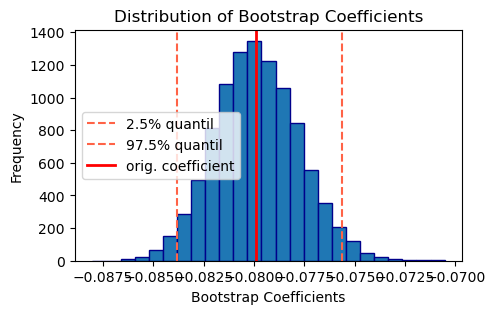

In [102]:
# Your Code goes here!
multi_sample_bs_model_coef = []
for i in range(10000):
    # resample the data
    sampled_users = dfout.sample(100, replace=True)
    # fit the model
    multi_sample_bs_model = LinearRegression()
    multi_sample_bs_model.fit(sampled_users[["Nr_Crimes"]], sampled_users["socnet"])
    # append the coefficient to the multi_sample_bs_model_coef list
    multi_sample_bs_model_coef.append(multi_sample_bs_model.coef_[0])
multi_sample_bs_model_coef = np.array(multi_sample_bs_model_coef) # Convert to array for simpler use later

confidence_interval = np.percentile(multi_sample_bs_model_coef, [2.5, 97.5])
print("95% conf. interval:", confidence_interval)

standard_error = np.std(multi_sample_bs_model_coef) / np.sqrt(len(multi_sample_bs_model_coef))
print("standard error:", standard_error)

fig, ax = plt.subplots(1, 1,  figsize=(5,3))
ax.hist(multi_sample_bs_model_coef, bins=25, edgecolor='darkblue') 
ax.set_title("Distribution of Bootstrap Coefficients")
ax.set_xlabel("Bootstrap Coefficients")
ax.set_ylabel("Frequency")

ax.axvline(confidence_interval[0], color="tomato", linestyle='dashed', label='2.5% quantil')
ax.axvline(confidence_interval[1], color="tomato", linestyle='dashed', label='97.5% quantil')
ax.axvline(model.coef_, color="red", linewidth=2, label='orig. coefficient')
ax.legend(loc=6)

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
#from pymer4.models import Lmer
#import pymer4.stats as pymers
from scipy.stats import zscore


def print_min_max(dframe):
    print("\t\t\tmin\t\tmax\n"
          f'unemp:\t\t{dframe["unemp_per_k"].min()}\t\t{dframe["unemp_per_k"].max()}\n'
          f'unemp_area:\t\t{dframe["unemp_area"].min()}\t\t{dframe["unemp_area"].max()}\n'
          f'density:\t{dframe["density"].min():.2f}\t{dframe["density"].max():.2f}\n'
          f'gdp:\t\t{dframe["gdp"].min()}\t{dframe["gdp"].max()}\n')
    return;

df = pd.read_csv("../data/normalized_data.csv")
df.loc[:, "year"] = df["TIME_PERIOD"]
del df["TIME_PERIOD"]
df["crimes"] = df['crime/population']
df["unemp_area"] = df['unemp per Tsd.']/df['area']
df["unemp_per_k"] = df['unemp per Tsd.']
df = df[~df["unemp_per_k"].isna()]
factors = ["gdp", "unemp_per_k", "unemp_area", "density"]

throwing 46 rows with outliers
throwing countries ['CZ', 'EE', 'HR'] with too few datapoints


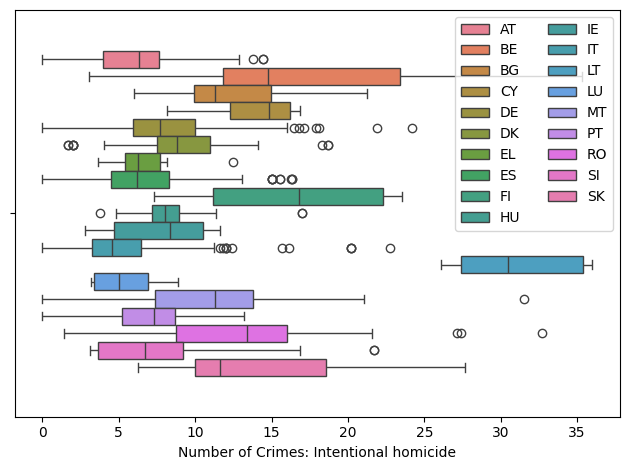

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


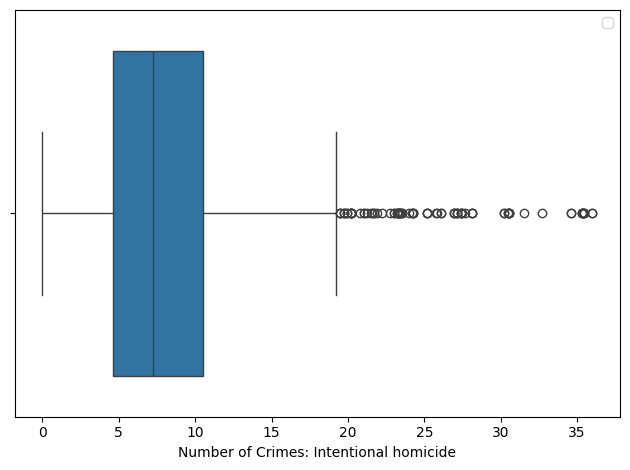

----------- Intentional homicide -----------
			min		max
unemp:		0.4		1149.1
unemp_area:		9.264143478834234e-05		0.2234096692111959
density:	9.36	2652.58
gdp:		32.0	395.0

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: crimes    
No. Observations: 1352    Method:             REML      
No. Groups:       19      Scale:              16.5349   
Min. group size:  11      Log-Likelihood:     -3868.5085
Max. group size:  334     Converged:          Yes       
Mean group size:  71.2                                  
--------------------------------------------------------
             Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------
Intercept    13.591    1.475  9.217 0.000  10.701 16.481
gdp          -0.031    0.004 -7.849 0.000  -0.039 -0.024
unemp_per_k  -0.001    0.001 -0.377 0.706  -0.003  0.002
unemp_area    6.678    9.725  0.687 0.492 -12.382 25.738
density       0.002    0.000  5.002 0.00

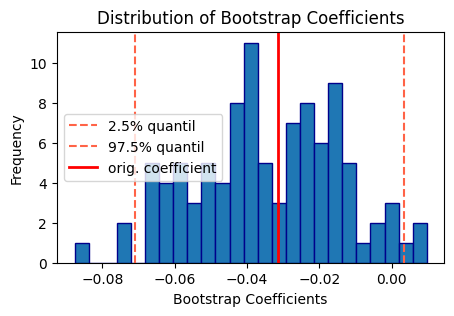

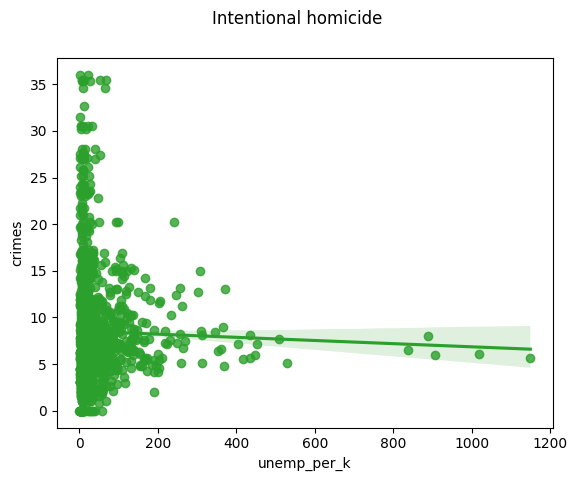

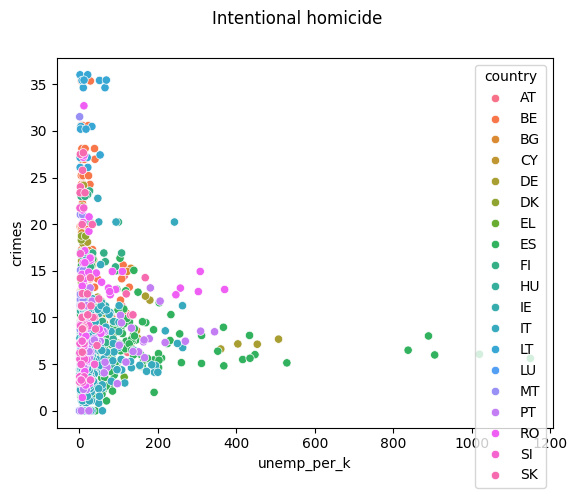

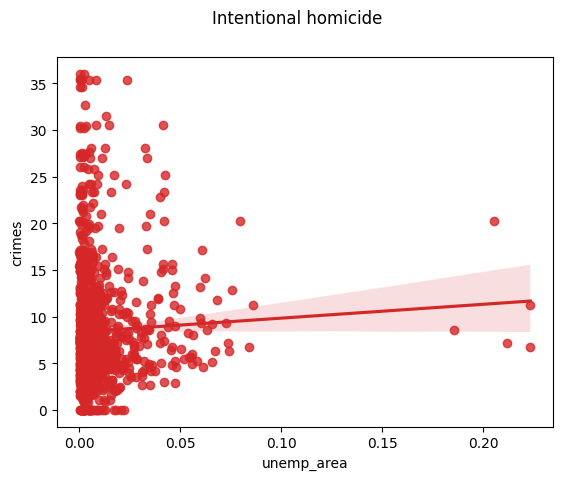

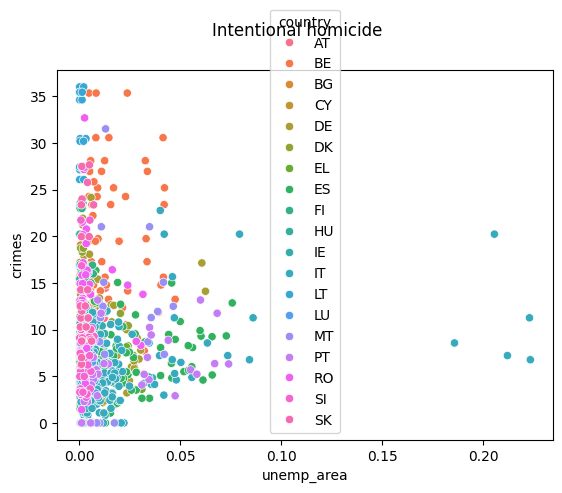

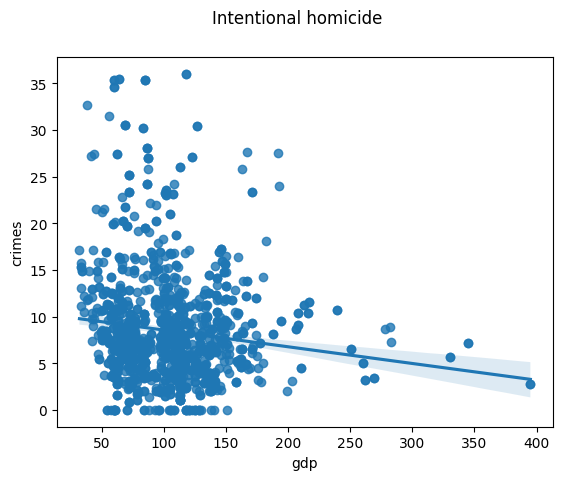

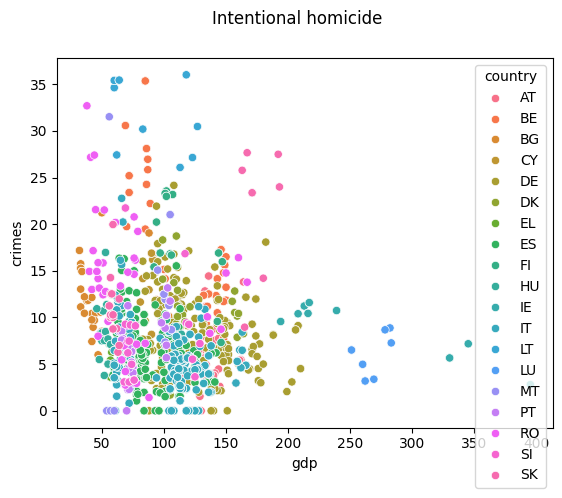

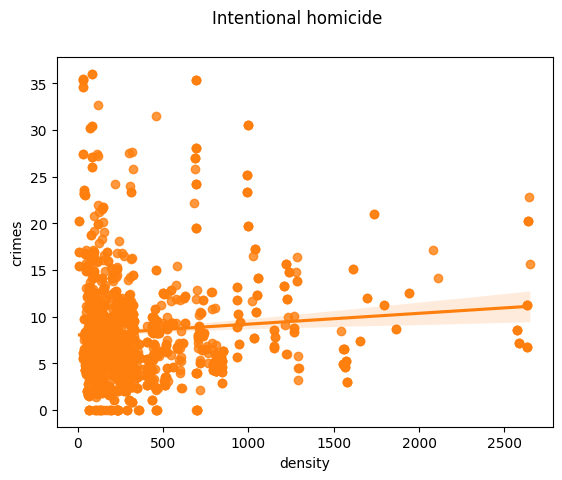

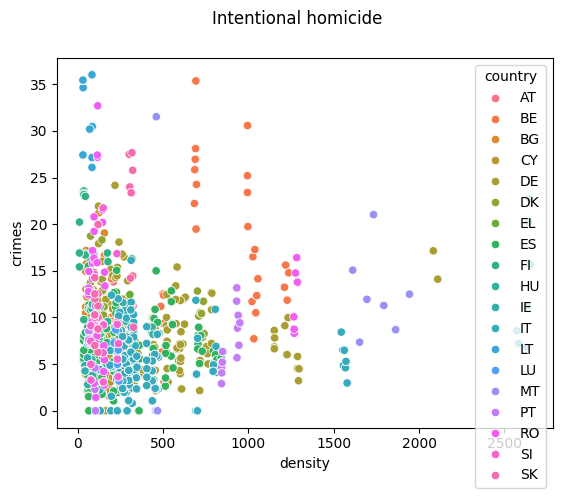


throwing 68 rows with outliers
throwing countries ['EE', 'HR', 'PL'] with too few datapoints


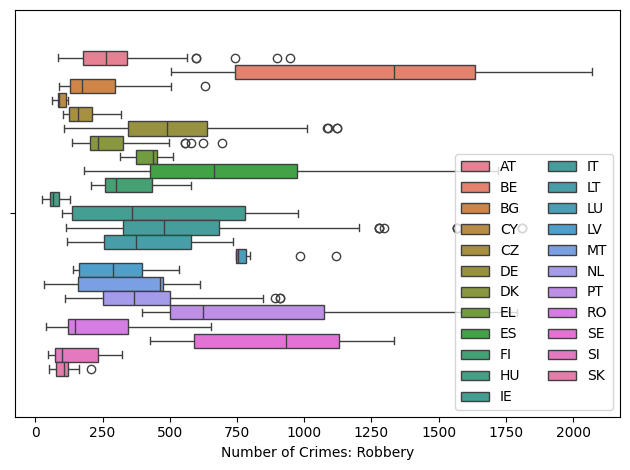

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


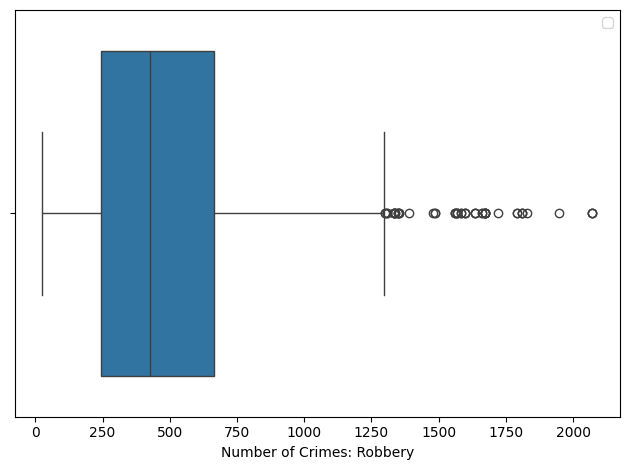

----------- Robbery -----------
			min		max
unemp:		0.4		1149.1
unemp_area:		7.572679250858853e-05		0.2234096692111959
density:	9.36	4106.59
gdp:		32.0	395.0

            Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  crimes     
No. Observations:   1590     Method:              REML       
No. Groups:         23       Scale:               51526.7436 
Min. group size:    11       Log-Likelihood:      -10920.7110
Max. group size:    330      Converged:           Yes        
Mean group size:    69.1                                     
-------------------------------------------------------------
              Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------
Intercept     319.620   61.860  5.167 0.000  198.376  440.863
gdp             0.093    0.212  0.439 0.661   -0.322    0.507
unemp_per_k     0.161    0.086  1.870 0.061   -0.008    0.329
unemp_area   2460.658  531.655  4.628 0.000 141

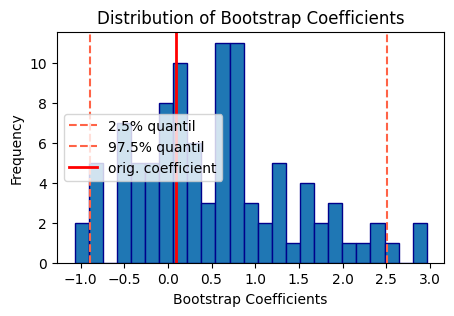

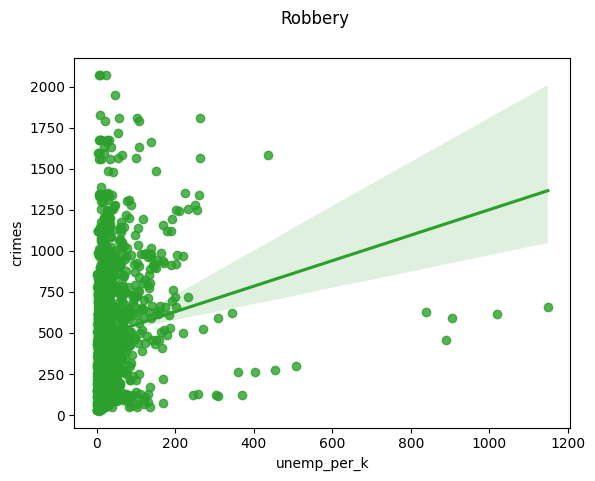

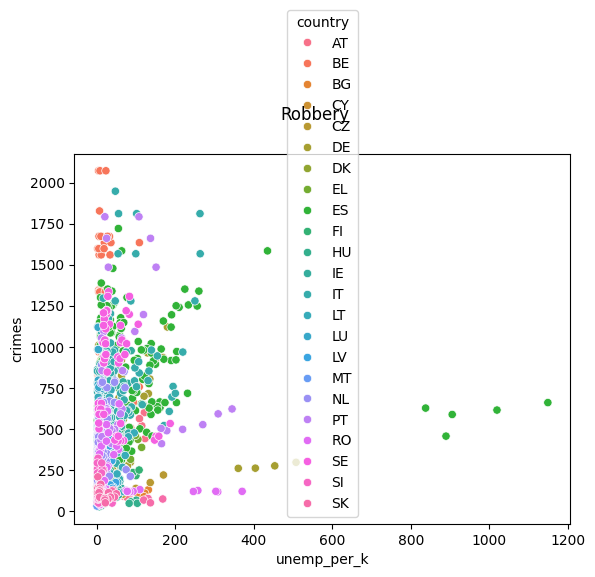

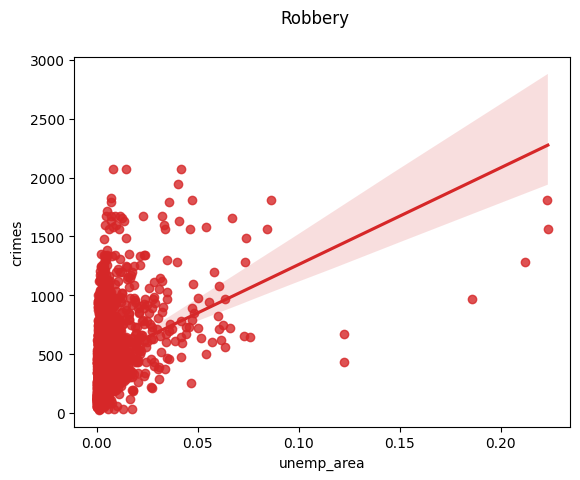

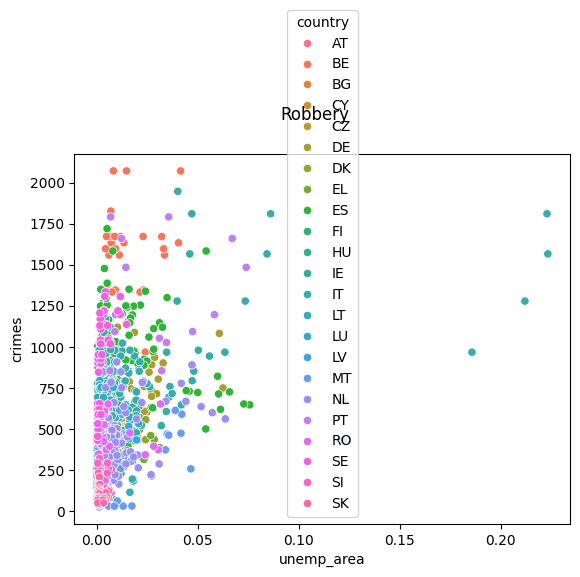

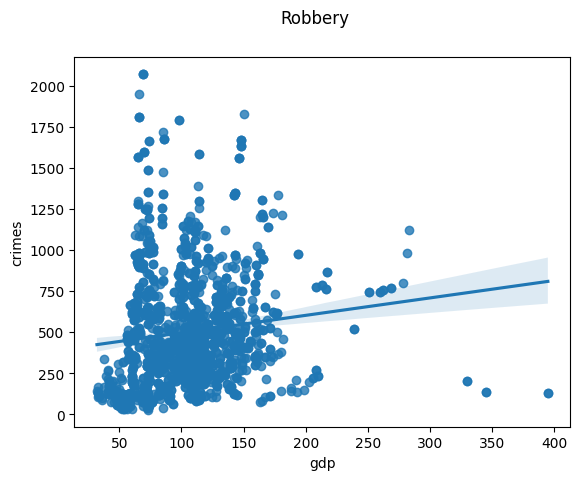

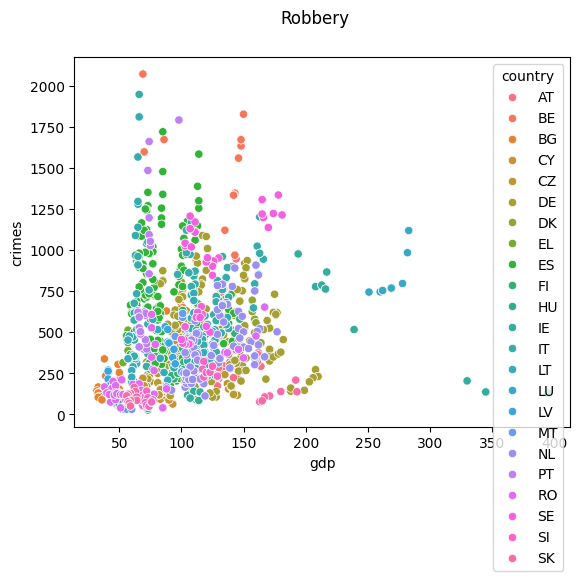

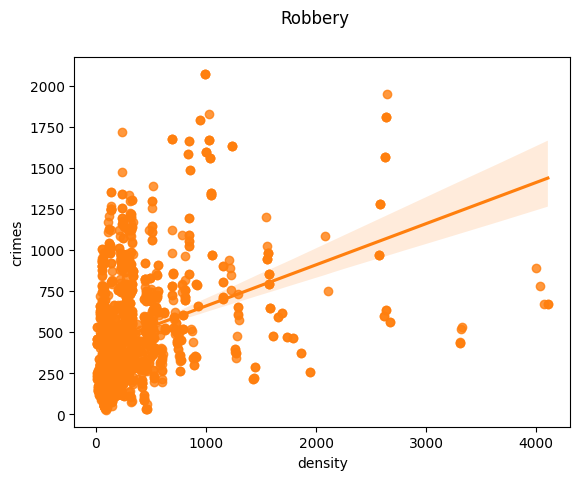

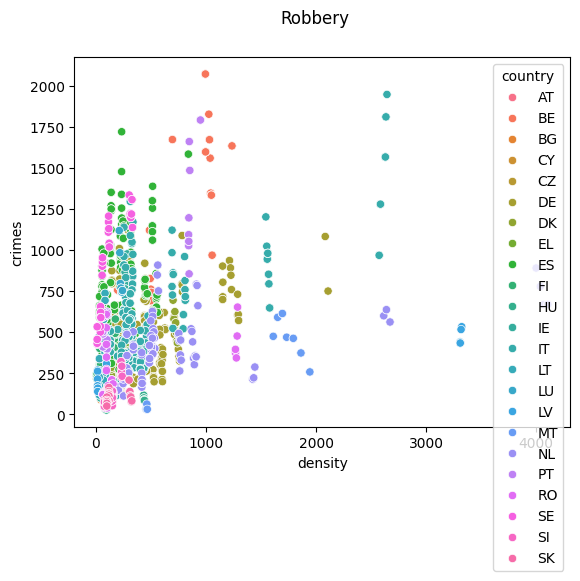


throwing 43 rows with outliers
throwing countries ['HR', 'LV'] with too few datapoints


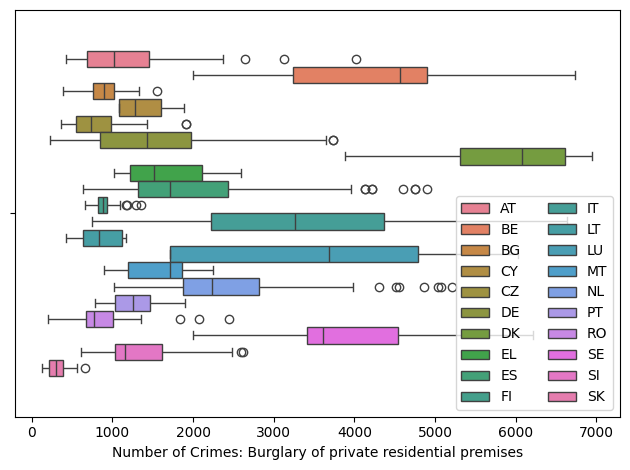

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


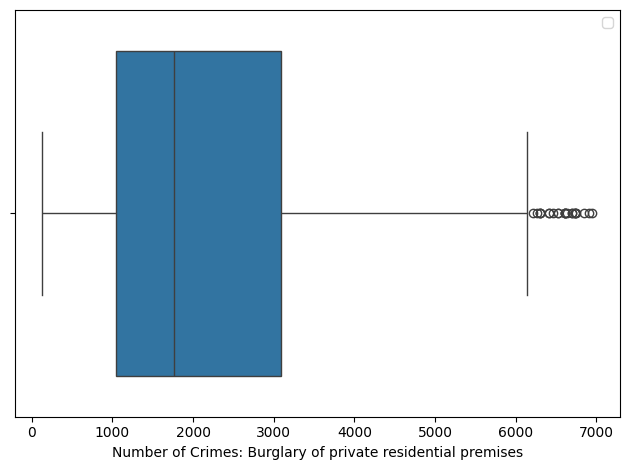

----------- Burglary of private residential premises -----------
			min		max
unemp:		0.4		1149.1
unemp_area:		9.151523074911752e-05		0.2234096692111959
density:	9.36	4106.59
gdp:		33.0	283.0

              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    crimes     
No. Observations:    1509       Method:                REML       
No. Groups:          20         Scale:                 782429.2542
Min. group size:     5          Log-Likelihood:        -12409.0182
Max. group size:     333        Converged:             Yes        
Mean group size:     75.5                                         
------------------------------------------------------------------
               Coef.    Std.Err.   z    P>|z|   [0.025     0.975] 
------------------------------------------------------------------
Intercept       888.560  306.987  2.894 0.004    286.877  1490.243
gdp              10.316    0.908 11.358 0.000      8.536    12.097
unemp_per_k       0

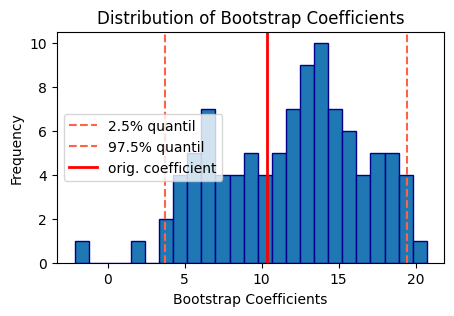

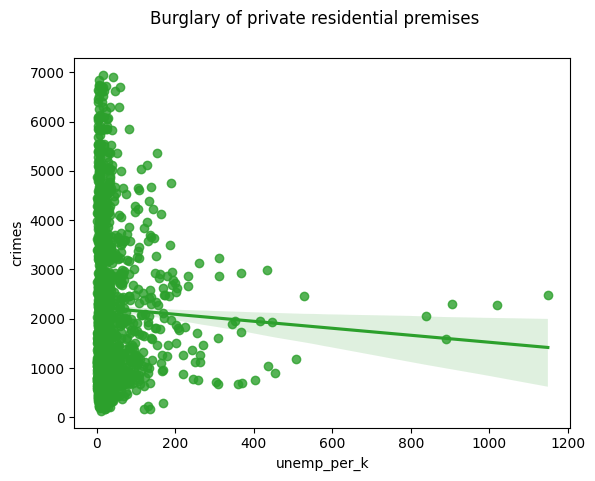

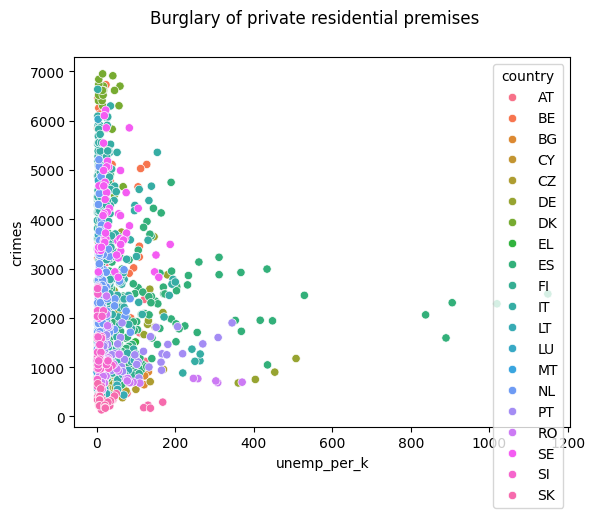

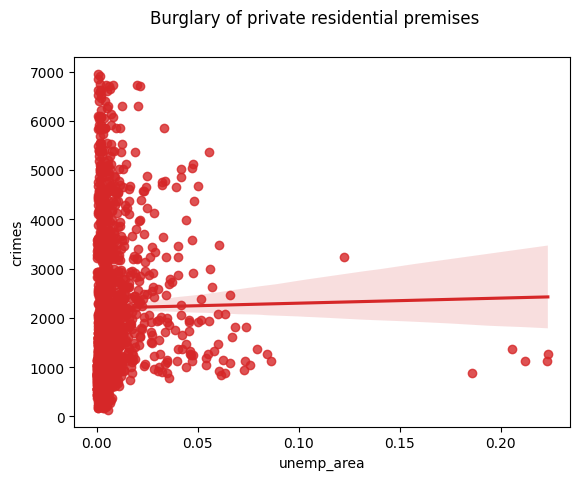

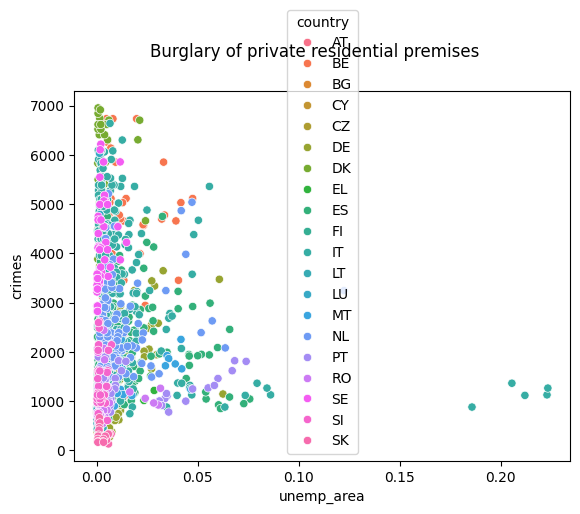

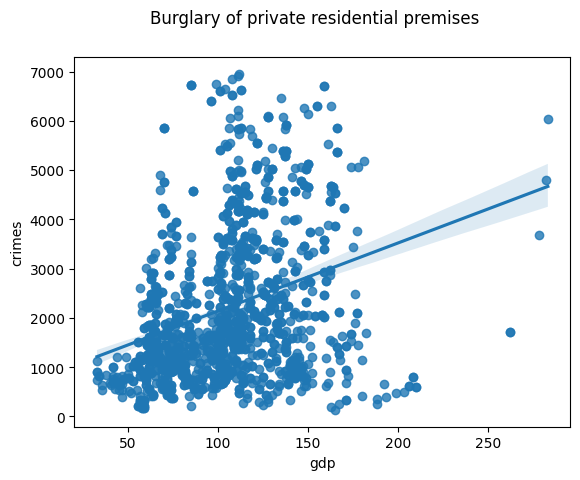

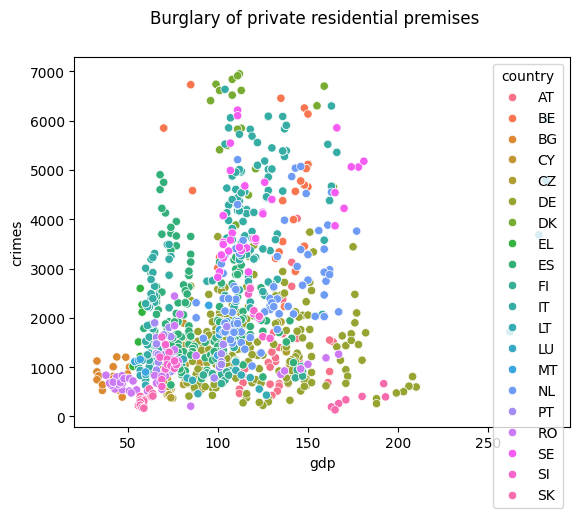

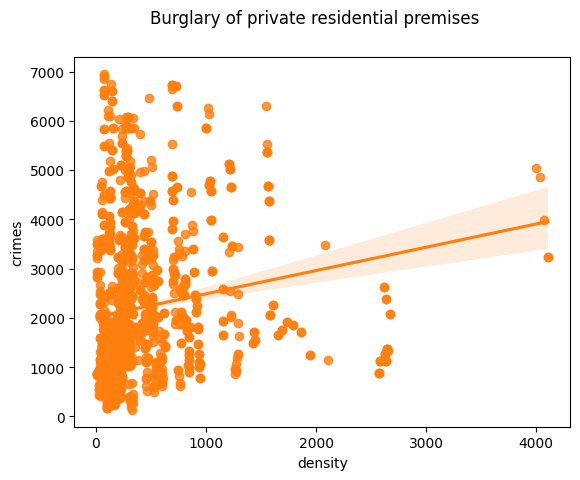

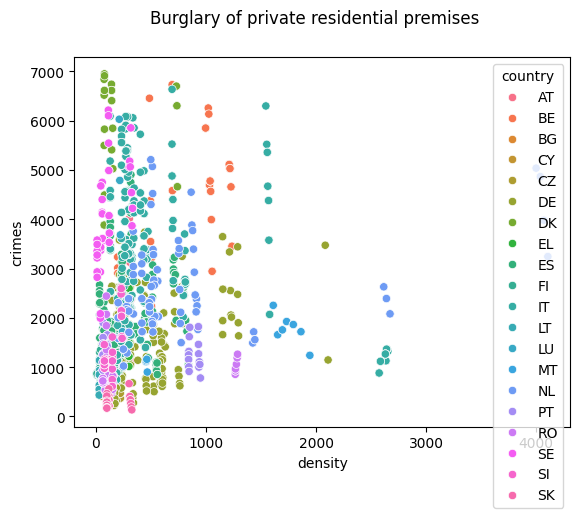


throwing 73 rows with outliers
throwing countries ['EE', 'HR'] with too few datapoints


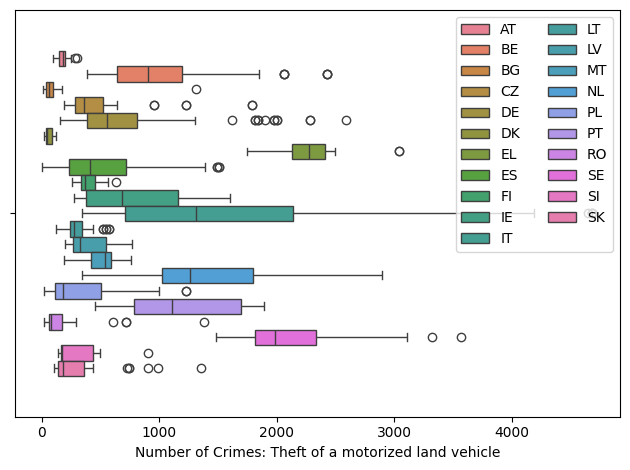

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


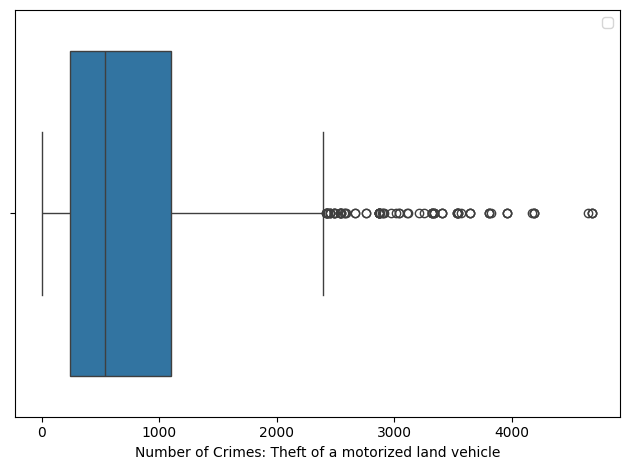

----------- Theft of a motorized land vehicle -----------
			min		max
unemp:		0.4		1149.1
unemp_area:		7.572679250858853e-05		0.12243346007604564
density:	9.36	4106.59
gdp:		33.0	395.0

            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  crimes     
No. Observations:    1656     Method:              REML       
No. Groups:          21       Scale:               268921.3973
Min. group size:     11       Log-Likelihood:      -12734.0802
Max. group size:     261      Converged:           Yes        
Mean group size:     78.9                                     
--------------------------------------------------------------
              Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
--------------------------------------------------------------
Intercept      647.003  147.647  4.382 0.000  357.621  936.385
gdp             -1.045    0.483 -2.162 0.031   -1.992   -0.098
unemp_per_k      0.362    0.169  2.136 0.033    0.030    0.693
unemp_ar

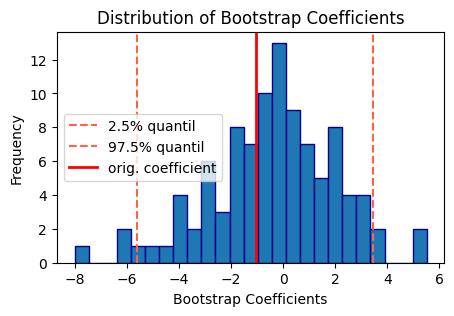

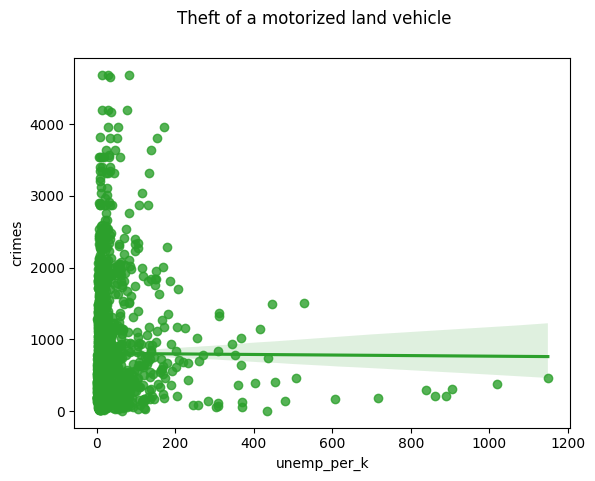

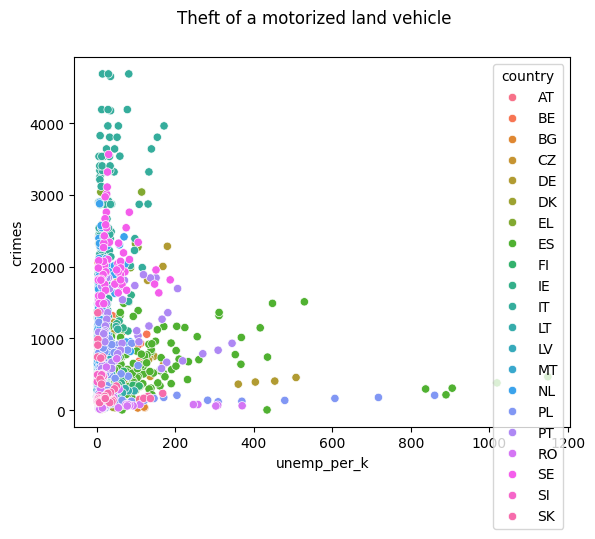

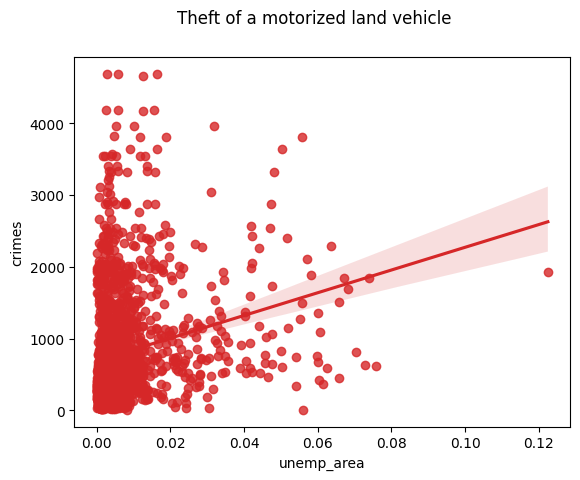

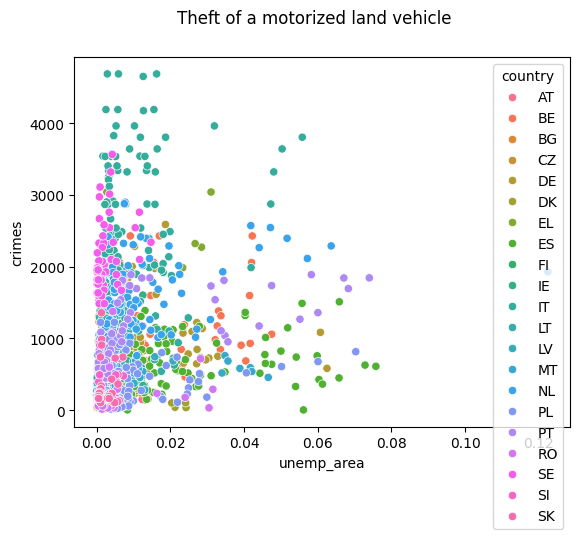

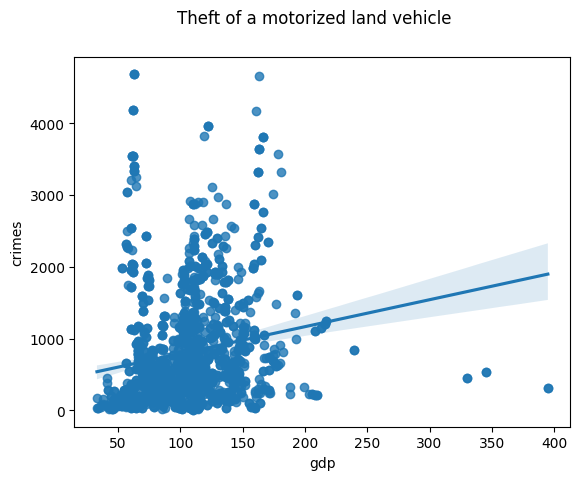

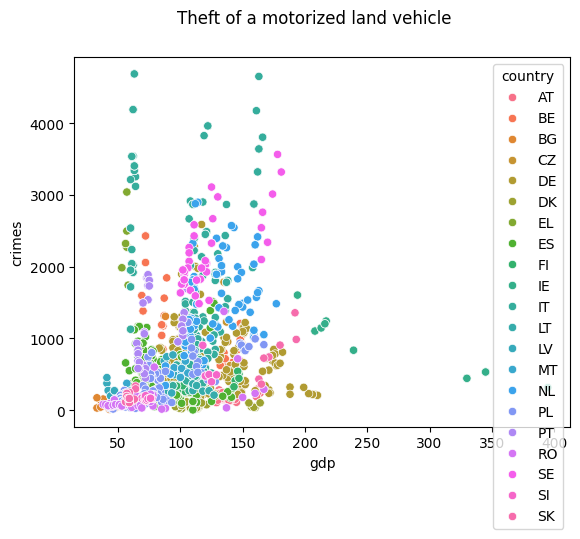

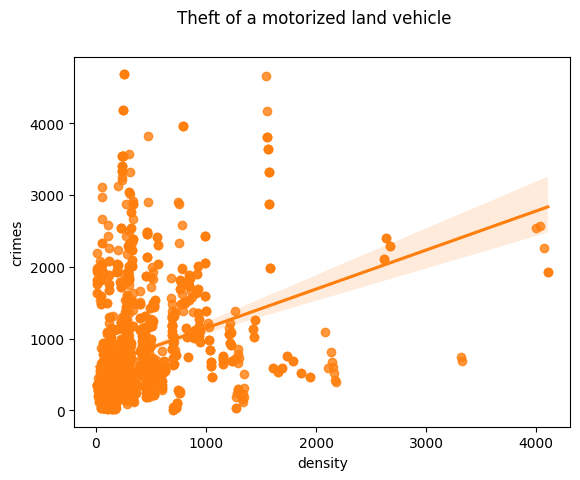

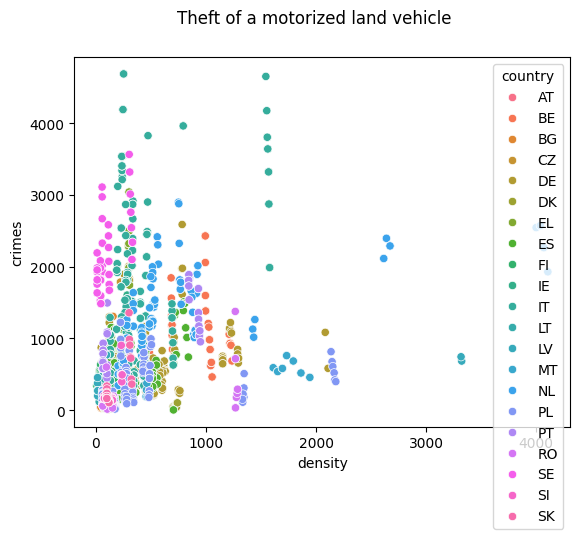

In [15]:

for crime, data in df.groupby(by="iccs"):

    crime_name = data["iccs_d"].unique()[0]

    # throw outlier countries
    lenbef = len(data)
    data = data[data["crimes"] <= (data["crimes"].median() + 3 * data["crimes"].std())]
    print(f"throwing {lenbef-len(data)} rows with outliers")
    # throw countries that have too few data points (now)
    countries = []
    for country, rows in data.groupby(by="country"):
        if len(rows["year"].unique()) <= 3:
            countries.append(country)
    print(f"throwing countries {countries} with too few datapoints")
    data = data[~data["country"].isin(countries)]

    # boxplots
    # plot number of crimes by country
    sns.boxplot(data, x="crimes", hue="country")
    plt.legend(ncol=2)
    plt.xlabel(f"Number of Crimes: {crime_name}")
    plt.tight_layout()
    #plt.savefig(f"plots/{crime}_{crime_name.split(' ')[0]}_Boxplots_Country.png")
    plt.show()
    # plot number of crimes in total
    sns.boxplot(data, x="crimes")
    plt.legend(ncol=2)
    plt.xlabel(f"Number of Crimes: {crime_name}")
    plt.tight_layout()
    #plt.savefig(f"plots/{crime}_{crime_name.split(' ')[0]}_Boxplots.png")
    plt.show()

    # overview on the data
    print(f"----------- {crime_name} -----------")
    print_min_max(data)

    # model
    model = sm.MixedLM.from_formula("crimes ~ gdp + unemp_per_k + unemp_area + density", groups="country", data=data)

#    model = Lmer("crimes ~ gdp + unemp_per_k + density + (1|country)", data=data)
    result = model.fit() # print(model.coefs) # print(model.fixef.head(5))
    #print(model.summary())
    print(result.summary())
    # model.plot_summary()
    # plt.show()
    
    
    # R^2
    y_true = model.endog
    y_pred = result.predict()
    R_squared = r2_score(y_true, y_pred)
    #R_squared = pymers.rsquared(model.data.crimes, model.residuals)
    print(f"R2c:\t\t{R_squared}\n")
    # df_res = len(data) - len(model.fixef.columns) - 1
    # R_squared_adj = pymers.rsquared_adj(R_squared, nobs=len(data), df_res=df_res)
    # print(f"R2:\t\t{R_squared}\n"
    #       f"R2_adj:\t{R_squared_adj}")

    multi_sample_bs_model_coef = []
    for i in range(100):
        # resample the data
        sampled_data = data.sample(100, replace=True)
        multi_sample_bs_model = sm.MixedLM.from_formula("crimes ~ gdp + unemp_per_k + unemp_area + density", groups="country", data=sampled_data)
        res1 = multi_sample_bs_model.fit()
        #multi_sample_bs_model_coef.append(multi_sample_bs_model.coef_[0])
        #multi_sample_bs_model_coef.append(res1.params[1])
        multi_sample_bs_model_coef.append(res1.params.iloc[1])
    multi_sample_bs_model_coef = np.array(multi_sample_bs_model_coef)
    
    # 95%-confidence_interval
    confidence_interval = np.percentile(multi_sample_bs_model_coef, [2.5, 97.5])
    print("95% conf. interval:", confidence_interval)
    # standard_error of Bootstrap
    standard_error = np.std(multi_sample_bs_model_coef) / np.sqrt(len(multi_sample_bs_model_coef))
    print("standard error:", standard_error)
    fig, ax = plt.subplots(1, 1,  figsize=(5,3))
    ax.hist(multi_sample_bs_model_coef, bins=25, edgecolor='darkblue') 
    ax.set_title("Distribution of Bootstrap Coefficients")
    ax.set_xlabel("Bootstrap Coefficients")
    ax.set_ylabel("Frequency")
    
    ax.axvline(confidence_interval[0], color="tomato", linestyle='dashed', label='2.5% quantil')
    ax.axvline(confidence_interval[1], color="tomato", linestyle='dashed', label='97.5% quantil')
    #ax.axvline(model.coef_, color="red", linewidth=2, label='orig. coefficient')
    ax.axvline(result.params.iloc[1], color="red", linewidth=2, label='orig. coefficient')
    
    ax.legend(loc=6)
    #plt.savefig(f"../plots/{crime}_{crime_name.split(' ')[0]}_{var}_bootstrap.png")
    plt.show()
    
    # plot regression lines
    for (var, colour) in [("unemp_per_k", "tab:green"), ("unemp_area", "tab:red"), ("gdp", "tab:blue"), ("density", "tab:orange")]:

        sns.regplot(x=var, y="crimes", data=data, fit_reg=True, color=colour)

#        sns.regplot(x=var, y="crimes", data=model.data, fit_reg=True, color=colour)
        plt.suptitle(crime_name)
        #plt.savefig(f"plots/{crime}_{crime_name.split(' ')[0]}_{var}_reg.png")
        plt.show()
        sns.scatterplot(data, x=var, y="crimes", hue="country")
        plt.suptitle(crime_name)
        #plt.savefig(f"plots/{crime}_{crime_name.split(' ')[0]}_{var}_scatter.png")
        plt.show()

        
    print('')


In [ ]:
 # plot regression lines by country
        #model.plot(param=var, ylabel="crimes", xlabel=var, grps=model.fixef.index.values.tolist())
        sns.regplot(x="gdp", y="crimes", data=data, fit_reg=True, color="tab:blue")
        plt.suptitle(crime_name)
        #plt.legend(["GDP", "Unemployment per 1000", "Population Density"])
        plt.show()
        sns.regplot(x="unemp_area", y="crimes", data=data, fit_reg=True, color="tab:green")
        plt.suptitle(crime_name)
        #plt.legend(["GDP", "Unemployment per 1000", "Population Density"])
        plt.show()
        sns.regplot(x="unemp_per_k", y="crimes", data=data, fit_reg=True, color="tab:red")
        plt.suptitle(crime_name)
        #plt.legend(["GDP", "Unemployment per 1000", "Population Density"])
        plt.show()
        sns.regplot(x="density", y="crimes", data=data, fit_reg=True, color="tab:orange")
        plt.suptitle(crime_name)
        #plt.legend(["GDP", "Unemployment per 1000", "Population Density"])
        plt.show()
        #plt.suptitle(crime_name)
        #plt.legend(model.fixef.index.values.tolist())
        #plt.savefig(f"plots/{crime}_{crime_name.split(' ')[0]}_{var}_reg_byCountry.png")
        #plt.show()